## Initial Setup

### Import necessary libraries

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import time
import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from rpca import RPCA

Following subject data and its quality:
- `S1.mat` $\rightarrow$ good subject data
- `S3.mat` $\rightarrow$ good subject data
- `S31.mat` $\rightarrow$ good subject data
- `S32.mat` $\rightarrow$ good subject data
- `S19.mat` $\rightarrow$ medium subject data
- `S29.mat` $\rightarrow$ bad subject data

In [3]:
NUM_SUBJECTS = 1
eeg_data_by_subject = np.empty((NUM_SUBJECTS, 64, 1500, 40, 6))

for subject in range(1, NUM_SUBJECTS+1):
    # Path to the compressed file
    compressed_file = f'./data/S{subject}.mat.7z'
    mat_file = f'./data/S{subject}.mat'

    # Check if the .mat file already exists
    if os.path.exists(mat_file):
        print(f"Using existing file {mat_file}")
    # Check if the compressed file exists
    elif os.path.exists(compressed_file):
        # Extract the file
        with py7zr.SevenZipFile(compressed_file, mode='r') as z:
            z.extractall()
        print(f"Successfully extracted {compressed_file}")
    else:
        print(f"File {compressed_file} not found")

    eeg_data_by_subject[subject - 1] = np.array(sio.loadmat(mat_file)['data'])

Using existing file ./data/S1.mat


### Define useful global variables

In [4]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

# Define all available channels with their corresponding indices
relevant_channels = {
    ### Secondary electrodes
    "FCz":18,
    "C5": 24,
    "C3": 25,
    "C1": 26,
    "C2": 28,
    "C4": 29,
    "C6": 30,
    "CPz": 37,
    "P7": 43,
    "P5": 44,
    "P3": 45,
    "P1": 46,
    "P2": 48,
    "P4": 49,
    "P6": 50,
    "P8": 51,

    ### Best electrodes
    ## Frontal
    "Cz": 27,
    
    ## Parietal
    "Pz": 47,
    
    ## Parieto-occipital
    "PO7": 52,
    "PO5": 53,
    "PO3": 54,
    
    "POz": 55,

    "PO4": 56,
    "PO6": 57,
    "PO8": 58,

    ## Occipital
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# Electrode sets with number of electrodes as key and channel name/index dict as value
channels_sets = {
    4:  {ch: relevant_channels[ch] for ch in ["POz", "O1", "Oz", "O2"]},
    8:  {ch: relevant_channels[ch] for ch in ["PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    9:  {ch: relevant_channels[ch] for ch in ["Pz", "PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    12: {ch: relevant_channels[ch] for ch in ["Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    14: {ch: relevant_channels[ch] for ch in ["P3", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    16: {ch: relevant_channels[ch] for ch in ["P3", "P1", "P2", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    18: {ch: relevant_channels[ch] for ch in ["P5", "P3", "P1", "P2", "P4", "P6", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    20: {ch: relevant_channels[ch] for ch in ["P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    22: {ch: relevant_channels[ch] for ch in ["FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    24: {ch: relevant_channels[ch] for ch in ["C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    26: {ch: relevant_channels[ch] for ch in ["C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    28: {ch: relevant_channels[ch] for ch in ["C5", "C6", "C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
}

selected_channels = channels_sets[9]

most_relevant_channels = {
    # "Pz": 47,
    # "POz": 55,
    # For most individuals
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

preprocessing_methods = ["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]

# mu and lambda values used for the best results
trial = 4
evoked_frequency = 8
start_sample = 375 # 1.5 second after the trial start
end_sample = 625 # 2.5 seconds after the trial start
should_use_power_ratios = False
should_use_model_accuracy = False

# variables used for BCI experiments
evoked_frequencies = [8, 10, 12, 15] # frequencies to be used for the BCI experiment (in Hz)
number_of_windows = 5 # number of windows to split into the useful trial interval (1 second segments along 5 seconds per trial)
number_of_trials = 6 # number of trials to use for the BCI experiment
bci_start_sample = 125 # the first 0.5 seconds are discarded
bci_end_sample = 1375 # the last 0.5 seconds are discarded

### Define useful functions

#### Pre-processing

In [5]:
## CAR
def apply_car_filter(eeg_data):
    """
    Apply Common Average Reference (CAR) filtering to EEG data.
    
    CAR subtracts the average of all electrodes from each individual electrode:
    V_i^CAR = V_i^EL - (1/n) * sum(V_j^EL) for all j electrodes
    
    Parameters:
    -----------
    eeg_data : numpy.ndarray
        Input EEG data with shape (channels, samples, frequencies, trials) or (channels, samples) or (trials, channels, samples)
        
    Returns:
    --------
    car_filtered : numpy.ndarray
        CAR-filtered EEG data with the same shape as the input
    """
    
    # Make a copy to avoid modifying the original data
    car_filtered = eeg_data.copy()
    
    # Determine if we have multiple multiple dimensions
    if len(eeg_data.shape) == 4:  # (channels, samples, frequencies, trials)
        n_of_trials = eeg_data.shape[3]
        n_of_frequencies = eeg_data.shape[2]
        # Calculate mean across channels for each trial
        for trial in range(n_of_trials):
            for freq in range(n_of_frequencies):
                channel_mean = np.mean(eeg_data[:, :, freq, trial], axis=0)
                car_filtered[:, :, freq, trial] = eeg_data[:, :, freq, trial] - channel_mean

    elif len(eeg_data.shape) == 3:  # (trials, channels, samples)
        # Calculate mean across channels for each trial
        channel_mean = np.mean(eeg_data, axis=1, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean

    else:  # (channels, samples)
        # Calculate mean across channels
        channel_mean = np.mean(eeg_data, axis=0, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean
    
    return car_filtered

## RPCA
def apply_rpca_filter(eeg_data, lambda_value, mu_value, selected_channels, start_sample, end_sample, evoked_frequencies):
    """
    Apply Robust Principal Component Analysis (RPCA) filtering to EEG data.

    RPCA decomposes the data matrix into two components:
    L: Low-rank component (representing the common background signal/neural activity)
    S: Sparse component (representing artifacts, outliers, and noise)

    The function processes the data in windows and returns both the low-rank (L) and
    sparse (S) components separately.

    Args:
        eeg_data: numpy.ndarray
            Input EEG data with shape (channels, samples, frequencies, trials) or
            (channels, samples) or (trials, channels, samples)
        lambda_value: float
            Regularization parameter for RPCA that controls the sparsity of S
        mu_value: float
            Step size parameter for the optimization algorithm in RPCA
        selected_channels: dict
            Dictionary mapping channel names to their indexes
        start_sample: int
            Starting sample index for processing
        end_sample: int
            Ending sample index for processing
        evoked_frequencies: list
            List of frequencies to be processed

    Returns:
        tuple of numpy.ndarray:
            L_pre_processed_eeg_data: Low-rank component with the same shape as the input
            S_pre_processed_eeg_data: Sparse component with the same shape as the input
    """
    start_time = time.time()
    # Get the indexes of selected channels
    selected_channels_indexes = list(selected_channels.values())

    # Initialize output array with same shape as input
    L_pre_processed_eeg_data = np.zeros_like(eeg_data)
    S_pre_processed_eeg_data = np.zeros_like(eeg_data)
    # Get the number of trials and frequencies
    n_trials = eeg_data.shape[3]

    rpca_time = 0
    # Process each trial and frequency separately
    for trial_idx in range(n_trials):
        for freq in evoked_frequencies:
            # Split the selected portion of EEG data into windows for processing
            windowing_start_time = time.time()
            windowed_eeg_data = np.split(
                eeg_data[selected_channels_indexes, start_sample:end_sample, frequency_to_index[freq], trial_idx],
                indices_or_sections=number_of_windows,
                axis=1
            )
            windowing_end_time = time.time()

            # Calculate the width (in samples) of each window for indexing
            window_width = windowed_eeg_data[0].shape[1]

            # Process each window separately
            for window_index, window in enumerate(windowed_eeg_data):
                # Initialize L and S components for current window
                L = np.zeros_like(window)
                S = np.zeros_like(window)

                # Apply RPCA decomposition to the current window
                # tolerance: convergence criterion
                # max_iteration: maximum number of iterations for the algorithm
                rpca_start_time = time.time()
                L_temp, S_temp = RPCA(window, lambda_value, mu_value, tolerance=10e-4, max_iteration=1000)
                rpca_end_time = time.time()
                rpca_time += (rpca_end_time - rpca_start_time)

                # Store the decomposition results
                L += L_temp
                S += S_temp

                # Calculate the current window's position in the original data
                window_start = start_sample + window_index * window_width
                window_end = start_sample + (window_index + 1) * window_width

                # Update the output with filtered data
                L_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = L
                S_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = S

    end_time = time.time()
    print(f"apply_rpca_filter execution time: {end_time - start_time:.4f} seconds")
    print(f"RPCA decomposition time: {rpca_time:.4f} seconds")
    print(f"Windowing time: {windowing_end_time - windowing_start_time:.4f} seconds")

    return L_pre_processed_eeg_data, S_pre_processed_eeg_data

#### Feature Extraction

In [6]:
## Feature extraction
def get_label_vector(evoked_frequencies):
    Y = np.zeros(number_of_windows * number_of_trials * len(evoked_frequencies), int)

    for i, frequency in enumerate(evoked_frequencies):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                Y[i * number_of_trials * number_of_windows + j * number_of_windows + k] += i

    return Y

def get_label_matrix(evoked_frequencies):
    Y = np.ones((number_of_windows * number_of_trials * len(evoked_frequencies), len(evoked_frequencies)), int)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if int(i / (number_of_windows * number_of_trials)) != j:
                Y[i, j] *= -1

    return Y

def get_feature_matrix_from_eeg_time_domain(pre_processed_eeg_data, evoked_frequencies, selected_channels, start_sample, end_sample, select_first_harmonic=False):
    # Start dividing pre processed EEG Data into windows
    selected_channels_indexes = list(selected_channels.values())
    windowed_eeg_data = np.split(
        pre_processed_eeg_data[selected_channels_indexes, start_sample:end_sample, :, :],
        indices_or_sections=number_of_windows,
        axis=1
    )

    print('Windowed data:', np.array(windowed_eeg_data).shape)

    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    # Prepare X for vstack
    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    # each column is a channel for a frequency and each row is a trial for a window
    # k is the window, j is the trial, i is the frequency, l is the channel
    frequencies_indexes = [frequency_to_index[freq] for freq in evoked_frequencies]
    for i, frequency_index in enumerate(frequencies_indexes):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                temp = np.array([])
                for l in range(len(selected_channels)):
                    channel_data = windowed_eeg_data[k][l, :, frequency_index, j]
                    channel_fft = np.abs(fft(channel_data))
                    temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X


#### Models

In [7]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#### Utils

In [28]:
## Data Extraction
def get_electrodes_data(eeg_data, trial, frequency, selected_channels, start_sample, end_sample):
    """
    Extract electrodes data for selected channels within a defined sample interval.
    
    Args:
        eeg_data: The EEG data matrix
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        selected_channels: Dictionary mapping channel names to indices
        start_sample: Starting sample index
        end_sample: Ending sample index
        
    Returns:
        Numpy array containing electrodes data for selected channels
    """
    frequency_index = frequency_to_index[frequency]
    electrodes_data = eeg_data[:, :, frequency_index, trial - 1]
    return electrodes_data[list(selected_channels.values()), start_sample:end_sample]

## Plotting
def plot_time_frequency(data_matrix, title_prefix, channels, 
                        time_range=time_range, freq_range=freq_range, frequency=None, 
                        figsize=(15, 10), freq_xlim=default_freq_xlim, show_grid=True):
    """
    Plot electrode data in both time and frequency domains.
    
    Args:
        data_matrix: Matrix containing electrode data with shape (electrodes, samples)
        title_prefix: Prefix string to add to plot titles
        channels: Dictionary mapping channel names to indices
        time_range: Array for time domain x-axis (default: global variable time_range)
        freq_range: Array for frequency domain x-axis (default: global variable freq_range)
        samples: Number of samples for FFT calculation (default: data_matrix.shape[1])
        frequency: Frequency value to display in title (default: global variable frequency)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
        freq_xlim: Tuple for frequency plot x-axis limits (default: (5, 35))
        show_grid: Whether to show grid on frequency plots (default: True)
        
    Returns:
        fig, axes: The figure and axes objects for further customization
    """
    electrode_indices = list(channels.values())
    samples = data_matrix.shape[1]
    
    # Create subplot grid with enough columns for all electrodes
    n_electrodes = len(electrode_indices)
    fig, axes = plt.subplots(2, n_electrodes, figsize=figsize)
    
    # Handle case of single electrode (axes won't be 2D)
    if n_electrodes == 1:
        axes = axes.reshape(2, 1)

    for i, electrode_index in enumerate(electrode_indices):
        electrode_data = data_matrix[electrode_index, :]
        electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

        # Time domain plot
        axes[0, i].plot(time_range, electrode_data)
        axes[0, i].set_xlabel("Time (ms)")
        axes[0, i].set_ylabel("Voltage (uV)")
        
        # Set title with channel name if available
        title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                title += f" - {channel_names[electrode_index]}"
        if frequency is not None:
            title += f" Potential for {frequency} Hz"
        axes[0, i].set_title(title)

        # Frequency domain plot
        freq_title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                freq_title += f" - {channel_names[electrode_index]}"
        freq_title += " Freq Distribution"
        if frequency is not None:
            freq_title += f" for {frequency} Hz"
        axes[1, i].set_title(freq_title)
        
        axes[1, i].plot(freq_range, electrode_fft)
        axes[1, i].set_xlabel("Frequency (Hz)")
        axes[1, i].set_ylabel("FFT Magnitude")
        
        if freq_xlim:
            # Set the x-axis limits to show from the first to the last value in freq_xlim
            if isinstance(freq_xlim, (list, tuple)) and len(freq_xlim) >= 2:
                axes[1, i].set_xlim(freq_xlim[0], freq_xlim[-1])
            
            # Add vertical grid lines at each frequency in freq_xlim
            if isinstance(freq_xlim, (list, tuple)):
                axes[1, i].set_xticks(freq_xlim)
                axes[1, i].grid(axis='x', linestyle='-', alpha=0.7)
            
        if show_grid:
            # Add regular grid for y-axis
            axes[1, i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return fig, axes

## Power Spectral Density Analysis
def power_spectral_density_welch(data_matrix, fs, start_sample, end_sample, nperseg=None):
    """
    Compute the Power Spectral Density (PSD) using Welch's method.

    Args:
        data_matrix: EEG data (channels, samples)
        fs: Sampling frequency (Hz)
        start_sample: Start index
        end_sample: End index
        nperseg: Segment length for Welch (default: fs/2)

    Returns:
        freqs (1D array), psd_values (2D array: channels x frequencies)
    """
    data_segment = data_matrix[:, start_sample:end_sample]
    
    if nperseg is None:
        nperseg = fs // 2  # Default to 0.5s segments

    freqs, psd_values = welch(data_segment, fs=fs, nperseg=nperseg, axis=1, window='hann')

    return freqs, psd_values

def calculate_band_to_total_ratio(
        data_matrix, fs=fs, start_sample=None, end_sample=None, evoked_frequency=evoked_frequency, band_width=1
    ):
    """
    Calculate the ratio of power in a frequency band centered on the evoked frequency
    to the total power in the 5-35 Hz range.
    
    Args:
        data_matrix: Matrix containing electrode data
        fs: Sampling frequency in Hz (default: global variable fs)
        start_sample: Starting sample index (default: 0)
        end_sample: Ending sample index (default: data_matrix.shape[1])
        evoked_frequency: Center frequency of the band of interest (default: global variable evoked_frequency)
        band_width: Width of the frequency band in Hz (default: 1 Hz)
        
    Returns:
        Ratio of band power to total power for each channel
    """
    if start_sample is None:
        start_sample = 0
    if end_sample is None:
        end_sample = data_matrix.shape[1]

    # Get frequencies and PSD
    freqs, psd_values = power_spectral_density_welch(data_matrix, fs, start_sample, end_sample)

    # Define frequency ranges
    total_range_mask = (freqs >= 5) & (freqs <= 35)
    band_range_mask = (freqs >= evoked_frequency - band_width/2) & (freqs <= evoked_frequency + band_width/2)
    
    # Calculate power in the specified ranges for each channel
    n_channels = psd_values.shape[0]
    ratios = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # Sum power in the total range (5-35 Hz)
        total_power = np.sum(psd_values[channel_idx, total_range_mask])
        
        # Sum power in the band around evoked frequency
        band_power = np.sum(psd_values[channel_idx, band_range_mask])
        
        # Calculate ratio
        ratios[channel_idx] = band_power / total_power if total_power > 0 else 0
    
    return ratios

def display_power_ratios_table(original_ratios, l_ratios, s_ratios, car_ratios, channel_names=None):
    """
    Create and display a pandas DataFrame showing band-to-total power ratios.
    
    Args:
        original_ratios: Band-to-total power ratios for original data
        l_ratios: Band-to-total power ratios for L component
        s_ratios: Band-to-total power ratios for S component
        channel_names: Optional list of channel names (default: Channel 1, Channel 2, etc.)
    
    Returns:
        pandas DataFrame with the ratios
    """
    import pandas as pd
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Original': original_ratios,
        'CAR Filtered': car_ratios,
        'L component': l_ratios,
        'S component': s_ratios
    })
    
    # Rename columns to represent channels
    df.columns.name = 'Component'
    
    # Set channel names if provided, otherwise use default naming
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(len(original_ratios))]
    
    df.index = channel_names
    df.index.name = 'Channel'
    
    # Return the transposed DataFrame (components as rows, channels as columns)
    return df.T

## Picking $\lambda$ and $\mu$

In [9]:
lamb_zero = 1 / np.sqrt(end_sample - start_sample)

mu_denominators = [1/10, 1, 2]

lamb_values = [lamb_zero, lamb_zero / 1.5, lamb_zero / 2, lamb_zero / 2.5, lamb_zero / 3,
               lamb_zero / 3.5, lamb_zero / 4, lamb_zero / 4.5, lamb_zero / 5, lamb_zero / 6,
               lamb_zero / 7, lamb_zero / 8, lamb_zero / 9, lamb_zero / 10, lamb_zero / 15]

In [10]:
# Initialize best lamb and mu for each preprocessing method by subject
best_lamb_list_by_subject = []
best_mu_list_by_subject = []
max_accuracy_list_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    eeg_data = eeg_data_by_subject[subject - 1]

    # Initialize variables to track the best parameters before the loops
    best_lamb_list = []
    best_mu_list = []
    max_accuracy_list = []

    for i, method in enumerate(preprocessing_methods):
        if method == 'CAR':
            # Create label representations for classification
            # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
            Y_vector = get_label_vector(evoked_frequencies)

            # Y_matrix: One-hot encoded matrix representation of labels
            # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
            Y_matrix = get_label_matrix(evoked_frequencies)

            best_lamb = None
            best_mu = None
            X = get_feature_matrix_from_eeg_time_domain(apply_car_filter(eeg_data), evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
            X_train, X_val, \
            Y_vector_train, Y_vector_val, \
            Y_matrix_train, Y_matrix_val = train_test_split(
                X,
                Y_vector,
                Y_matrix,
                test_size=0.2,
                stratify=Y_vector,
                random_state=42  # For reproducibility
            )

            svm_model = SVC(kernel='linear')
            svm_model.fit(X_train, Y_vector_train)
            y_svm_pred = svm_model.predict(X_val)
            svm_acc = accuracy_score(Y_vector_val, y_svm_pred)
            max_accuracy = svm_acc
        else:
            best_lamb = lamb_zero
            best_mu = best_lamb / 2
            max_accuracy = 0

        best_lamb_list.append(best_lamb)
        best_mu_list.append(best_mu)
        max_accuracy_list.append(max_accuracy)

    # Create label representations for classification
    # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
    Y_vector = get_label_vector(evoked_frequencies)

    # Y_matrix: One-hot encoded matrix representation of labels
    # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
    Y_matrix = get_label_matrix(evoked_frequencies)

    for i, method in enumerate(preprocessing_methods):
        if method == 'CAR':
            continue

        for j, lamb in enumerate(lamb_values):
            for k, mu_denominator in enumerate(mu_denominators):
                mu = lamb / mu_denominator

                if method == 'RPCA_L':

                    X = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(eeg_data, lamb, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[0], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'RPCA_S':

                    X = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(eeg_data, lamb, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[1], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_L':

                    X = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(apply_car_filter(eeg_data), lamb, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[0], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_S':
                    
                    X = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(apply_car_filter(eeg_data), lamb, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[1], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                    
                    
                X_train, X_val, \
                Y_vector_train, Y_vector_val, \
                Y_matrix_train, Y_matrix_val = train_test_split(
                    X,
                    Y_vector,
                    Y_matrix,
                    test_size=0.2,
                    stratify=Y_vector,
                    random_state=42  # For reproducibility
                )

                # Train SVM model
                svm_model = SVC(kernel='linear')
                svm_model.fit(X_train, Y_vector_train)
                y_svm_pred = svm_model.predict(X_val)
                svm_acc = accuracy_score(Y_vector_val, y_svm_pred)
                
                if svm_acc > max_accuracy_list[i]:
                    max_accuracy_list[i] = svm_acc
                    best_lamb_list[i] = lamb
                    best_mu_list[i] = mu

    best_lamb_list_by_subject.append(best_lamb_list)
    best_mu_list_by_subject.append(best_mu_list)
    max_accuracy_list_by_subject.append(max_accuracy_list)


Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 0.0820 seconds
RPCA decomposition time: 0.0361 seconds
Windowing time: 0.0000 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 10.1280 seconds
RPCA decomposition time: 10.0180 seconds
Windowing time: 0.0005 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 8.0768 seconds
RPCA decomposition time: 7.9725 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 0.0643 seconds
RPCA decomposition time: 0.0190 seconds
Windowing time: 0.0000 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 8.6543 seconds
RPCA decomposition time: 8.6110 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 6.08

In [11]:
# Print per subject
for subj_idx in range(len(max_accuracy_list_by_subject)):
    print(f"\nSubject {subj_idx+1}:")
    for i, method in enumerate(preprocessing_methods):
        print(f"{method}: {max_accuracy_list_by_subject[subj_idx][i]:.4f}")
    
    print(best_lamb_list_by_subject[subj_idx])
    print(best_mu_list_by_subject[subj_idx])

# Calculate mean and std across subjects for each method
print("\nMean and std across subjects:")
for i, method in enumerate(preprocessing_methods):
    accs = [max_accuracy_list_by_subject[subj_idx][i] for subj_idx in range(len(max_accuracy_list_by_subject))]
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"{method}: mean={mean_acc:.4f}, std={std_acc:.4f}")



Subject 1:
CAR: 0.9167
RPCA_L: 0.7917
RPCA_S: 0.9167
CAR_RPCA_L: 0.9167
CAR_RPCA_S: 0.9583
[None, np.float64(0.06324555320336758), np.float64(0.03162277660168379), np.float64(0.06324555320336758), np.float64(0.042163702135578386)]
[None, np.float64(0.03162277660168379), np.float64(0.3162277660168379), np.float64(0.6324555320336758), np.float64(0.042163702135578386)]

Mean and std across subjects:
CAR: mean=0.9167, std=0.0000
RPCA_L: mean=0.7917, std=0.0000
RPCA_S: mean=0.9167, std=0.0000
CAR_RPCA_L: mean=0.9167, std=0.0000
CAR_RPCA_S: mean=0.9583, std=0.0000


apply_rpca_filter execution time: 8.5216 seconds
RPCA decomposition time: 8.3606 seconds
Windowing time: 0.0001 seconds


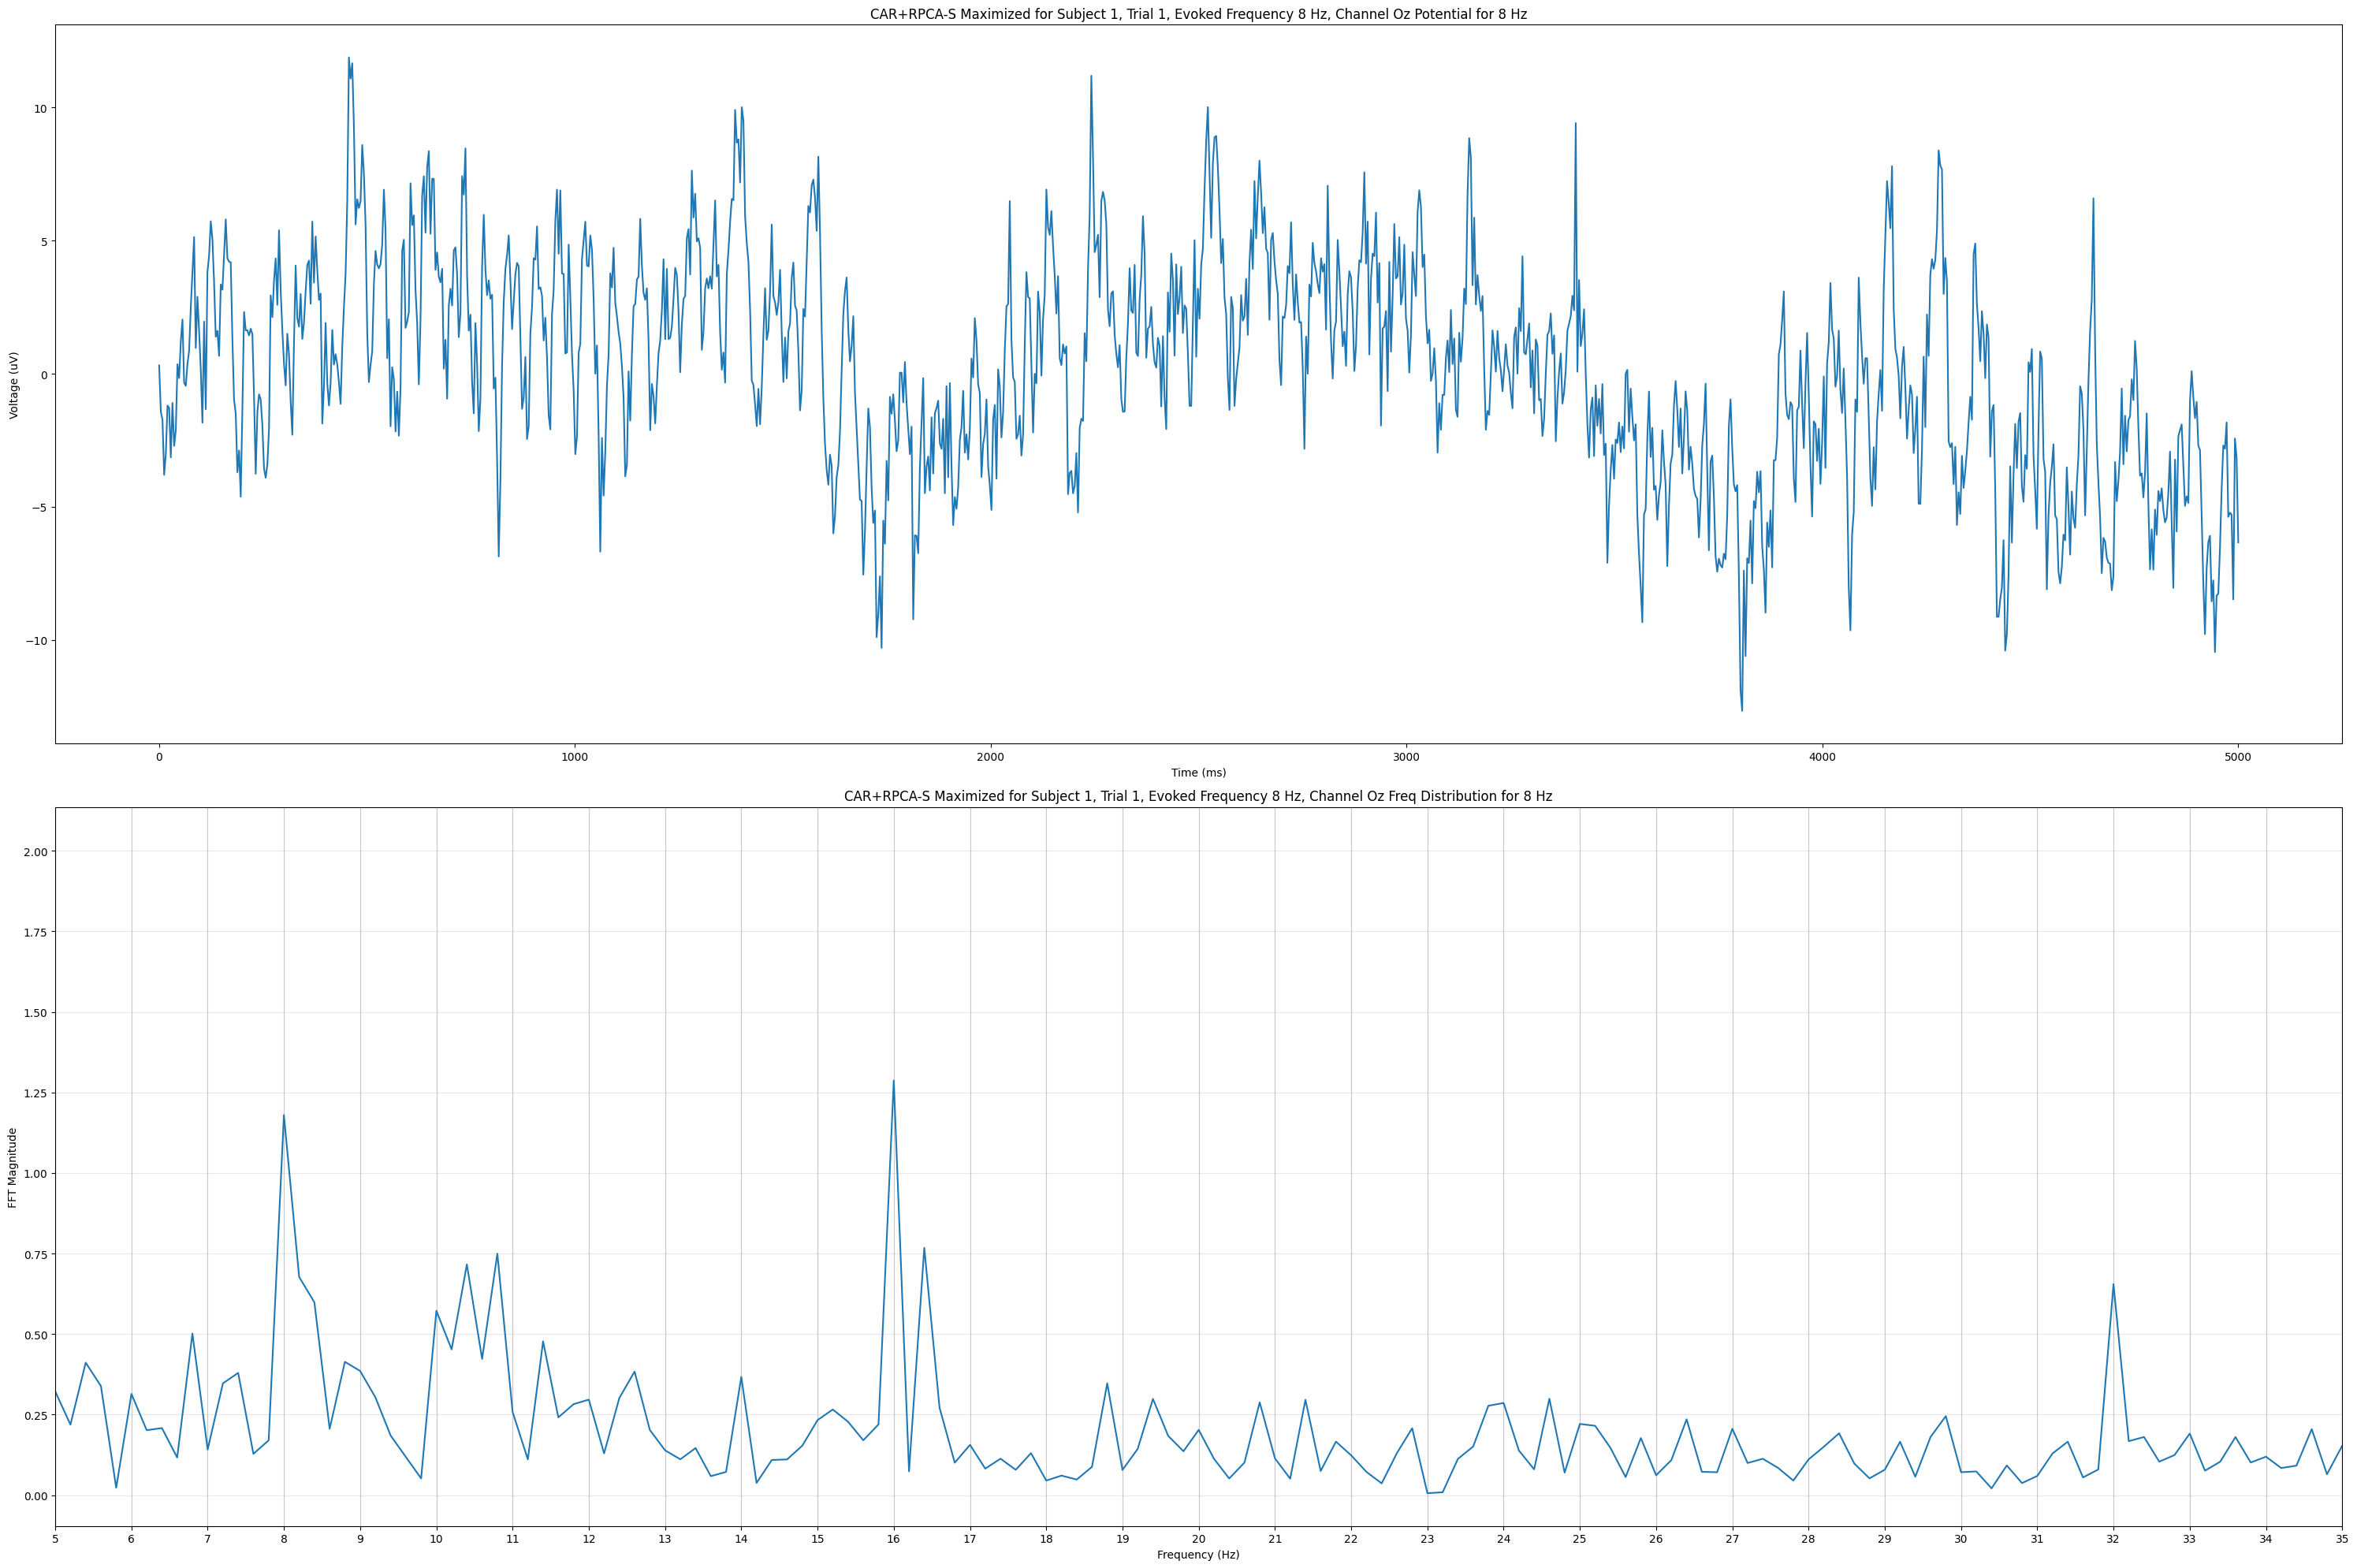

apply_rpca_filter execution time: 8.4434 seconds
RPCA decomposition time: 8.3261 seconds
Windowing time: 0.0001 seconds


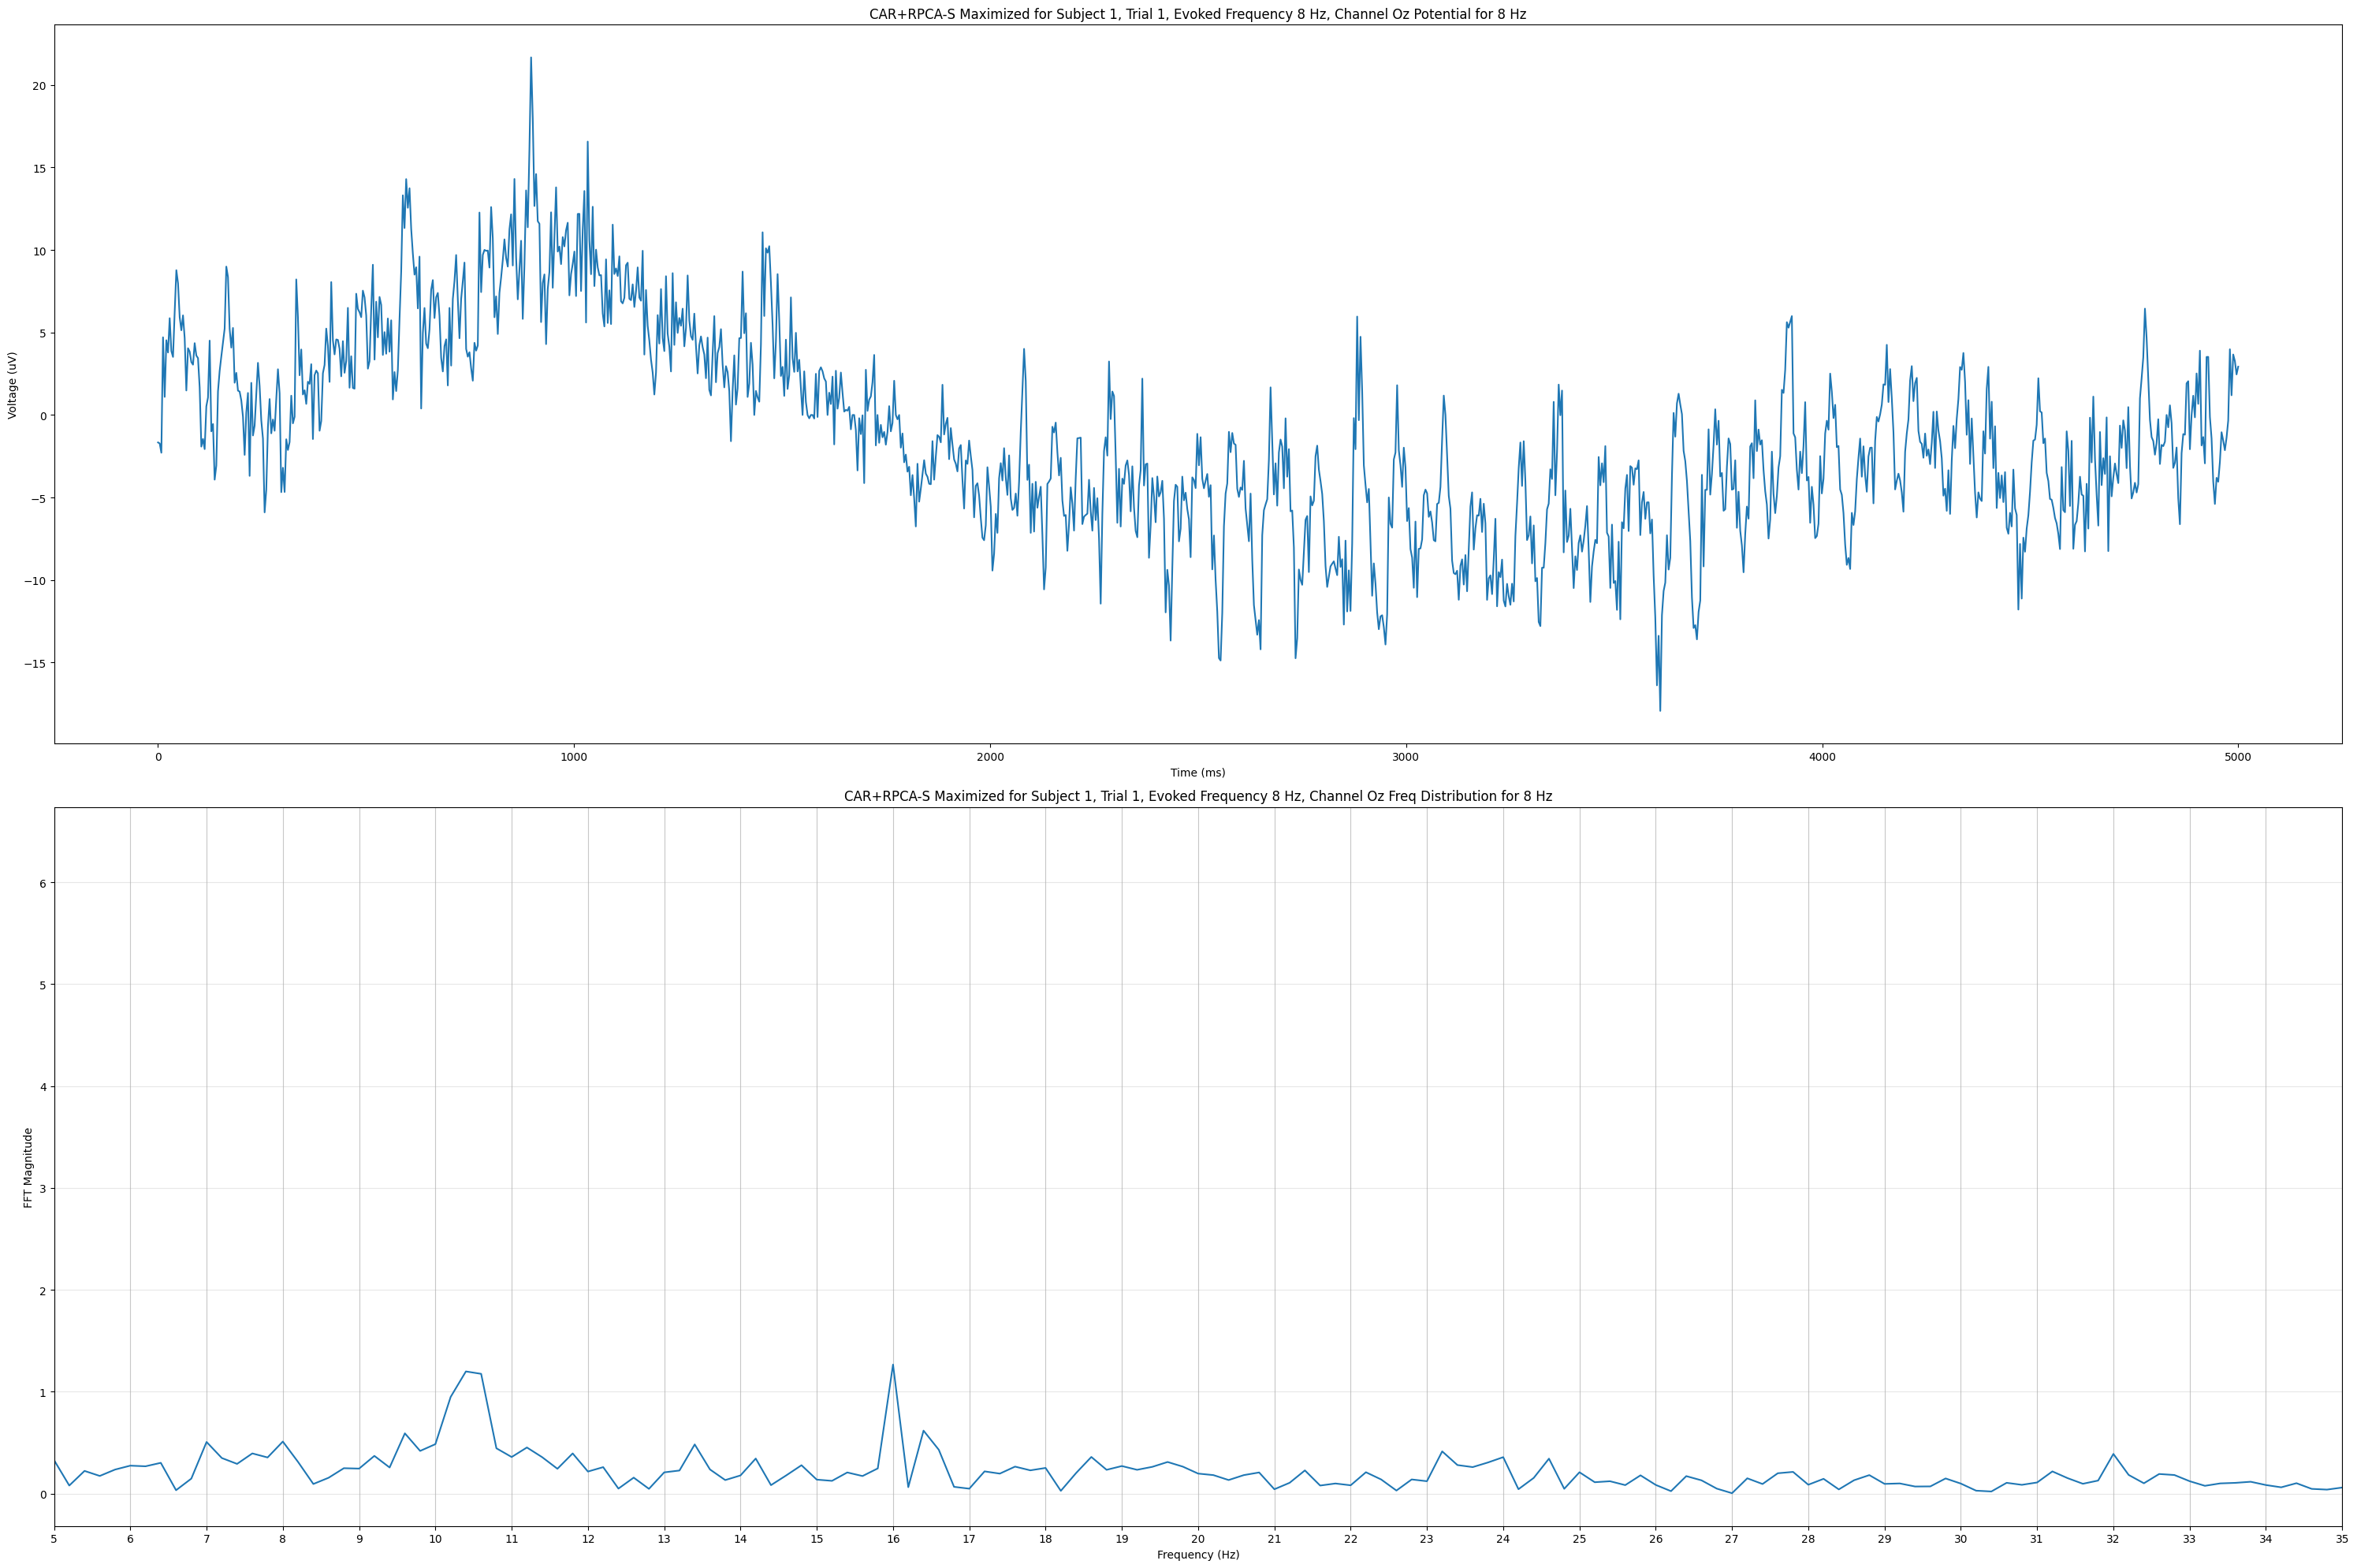

apply_rpca_filter execution time: 7.9146 seconds
RPCA decomposition time: 7.8201 seconds
Windowing time: 0.0001 seconds


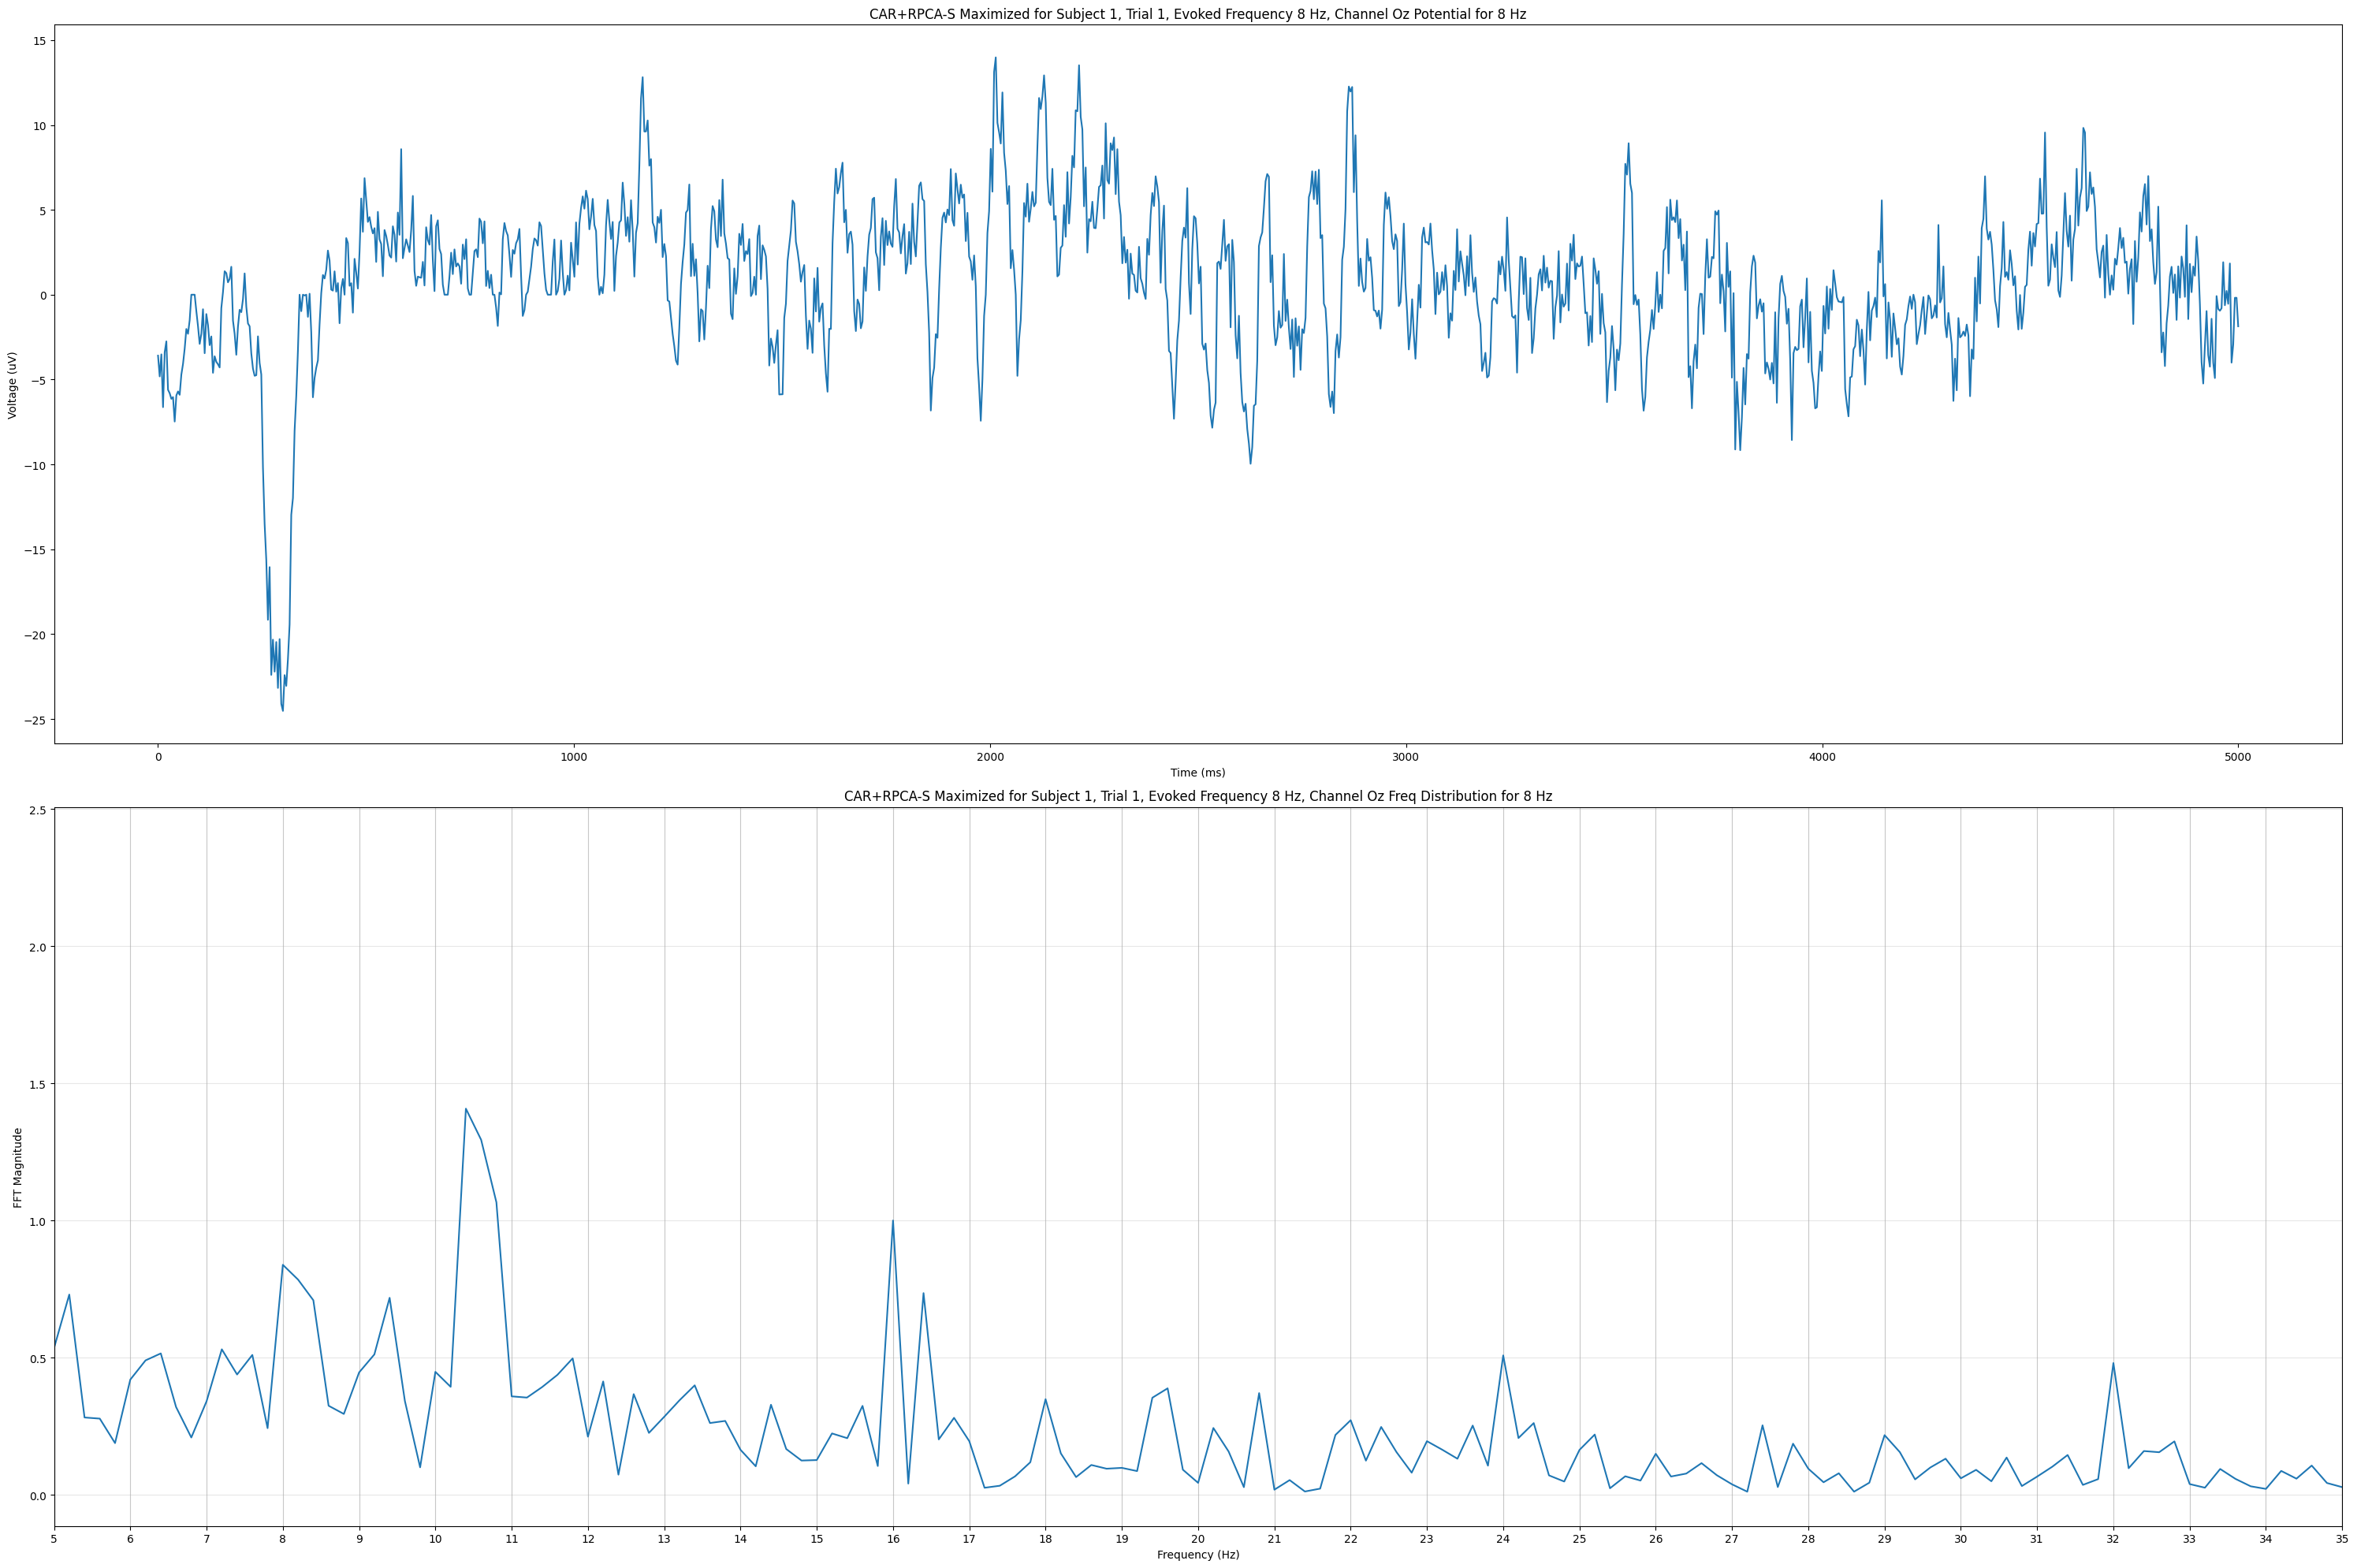

apply_rpca_filter execution time: 7.5991 seconds
RPCA decomposition time: 7.4714 seconds
Windowing time: 0.0001 seconds


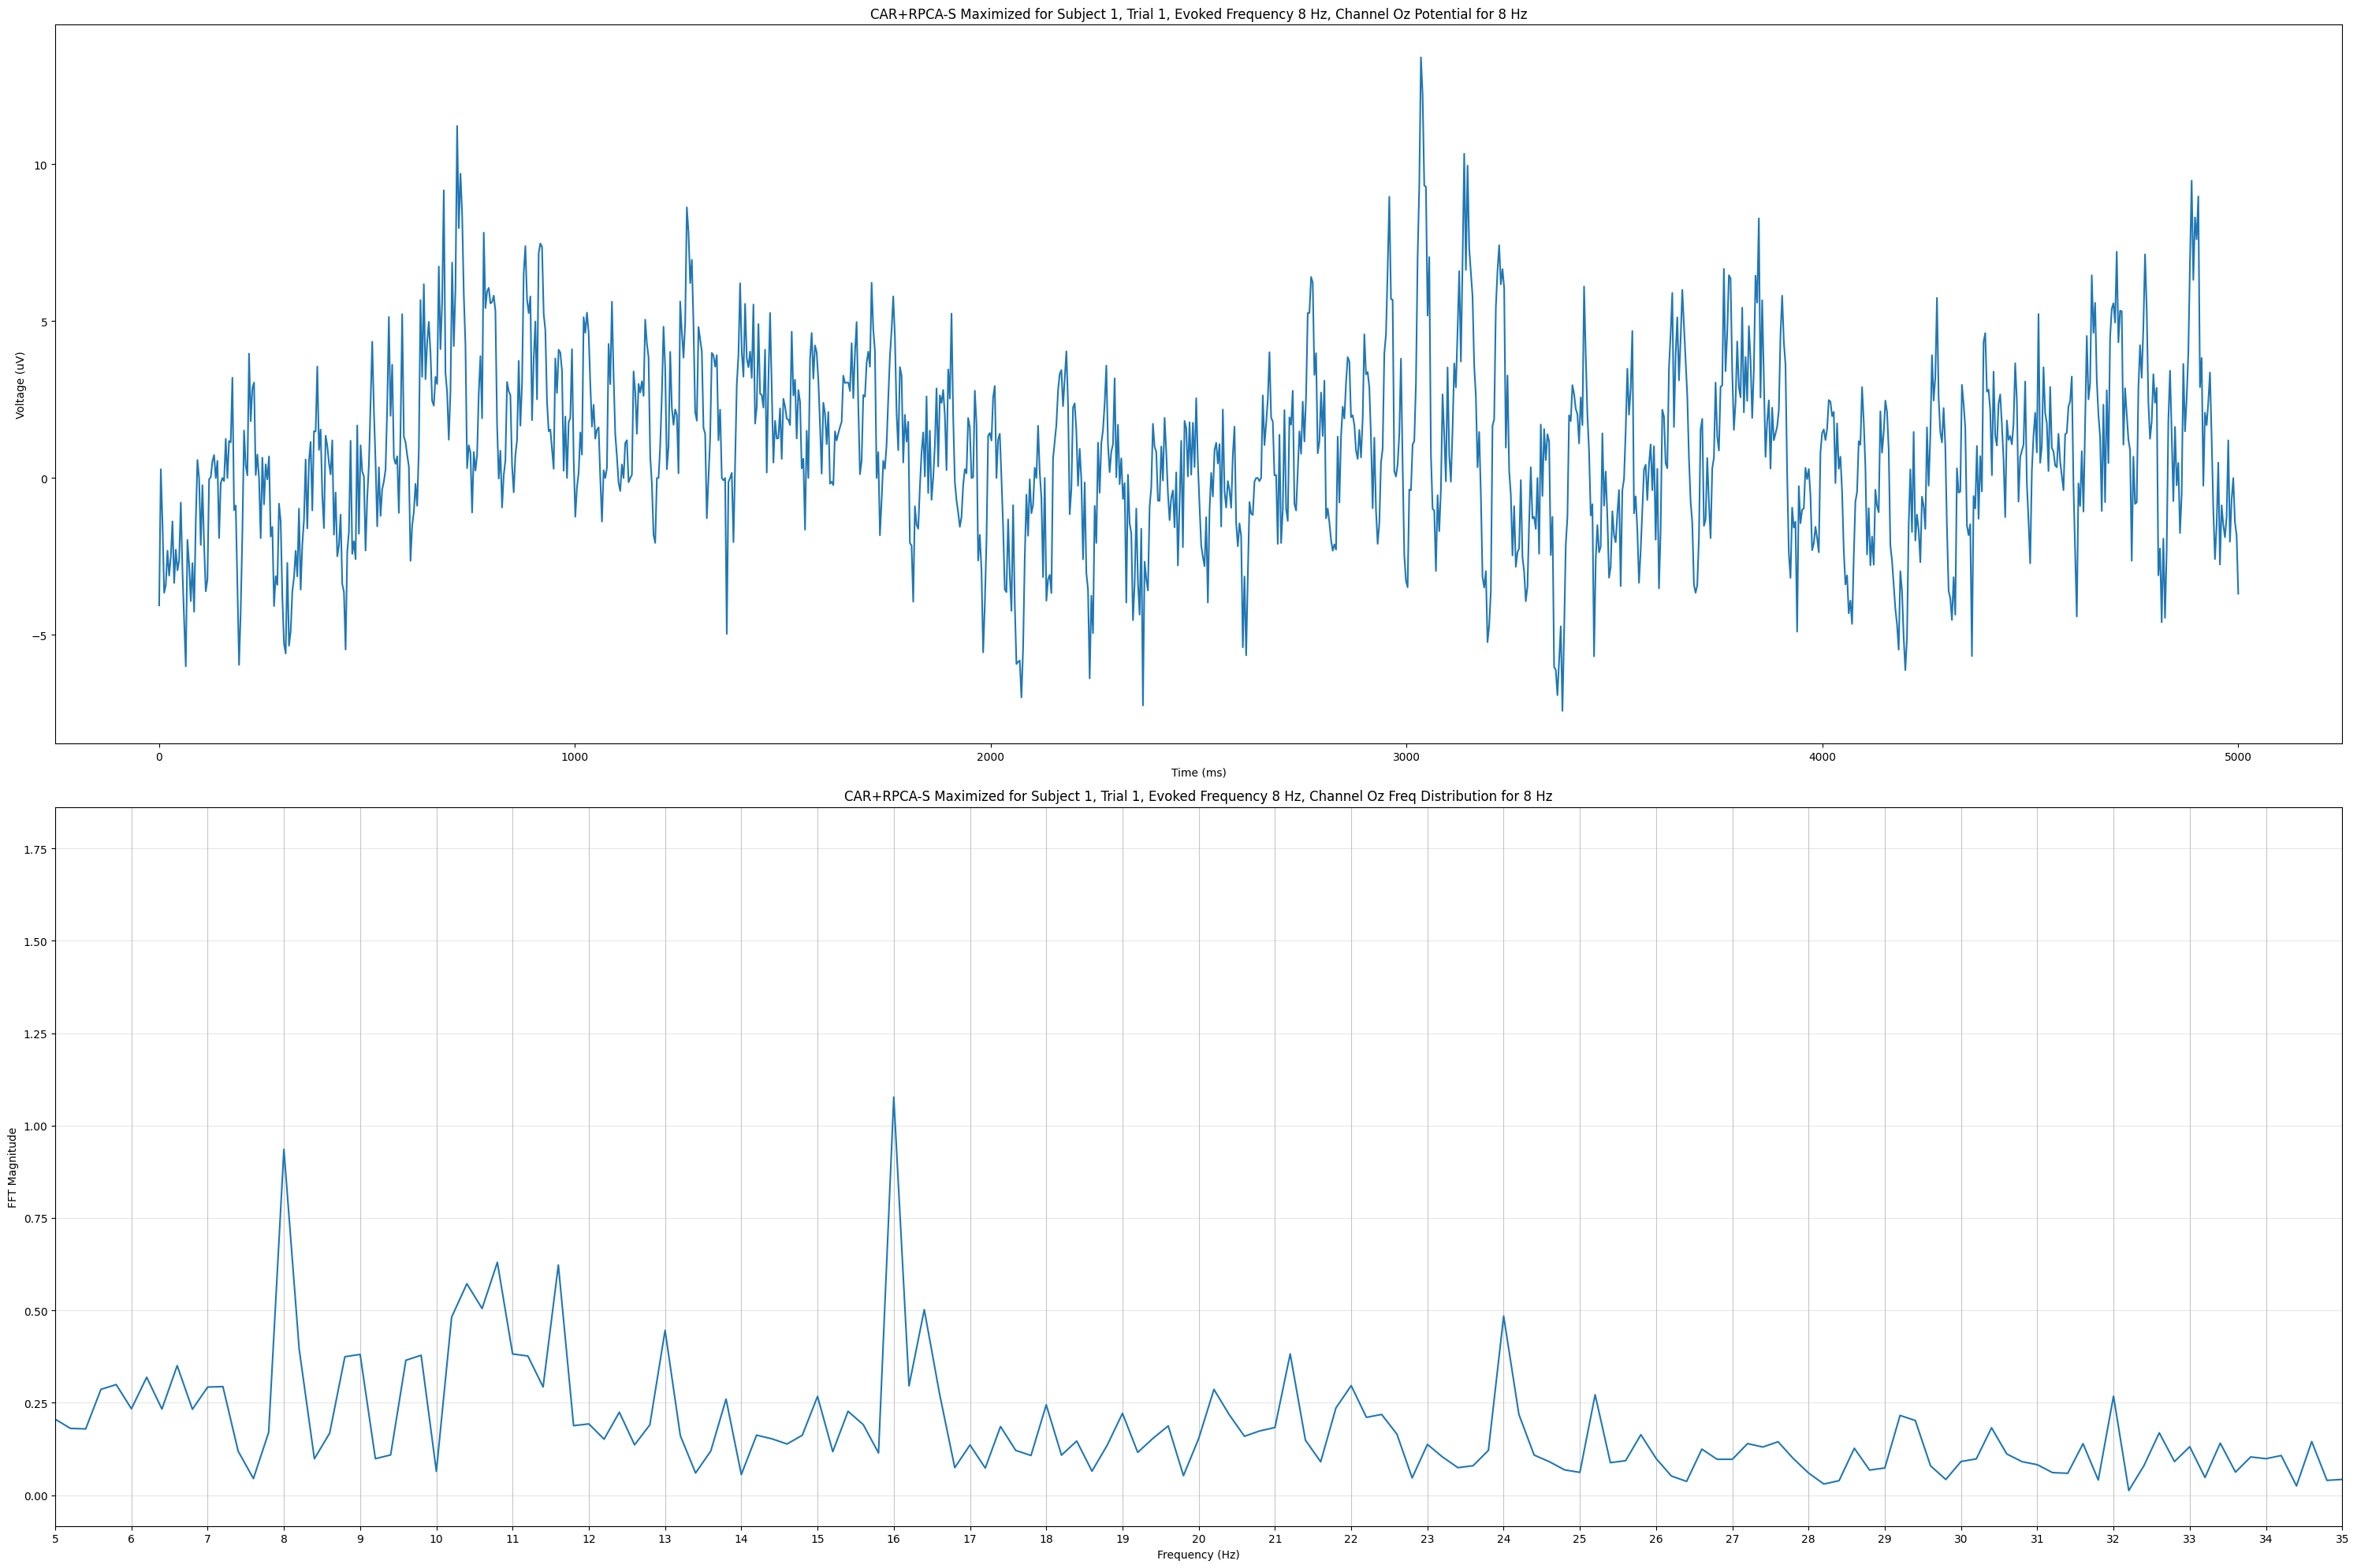

apply_rpca_filter execution time: 7.4620 seconds
RPCA decomposition time: 7.3369 seconds
Windowing time: 0.0001 seconds


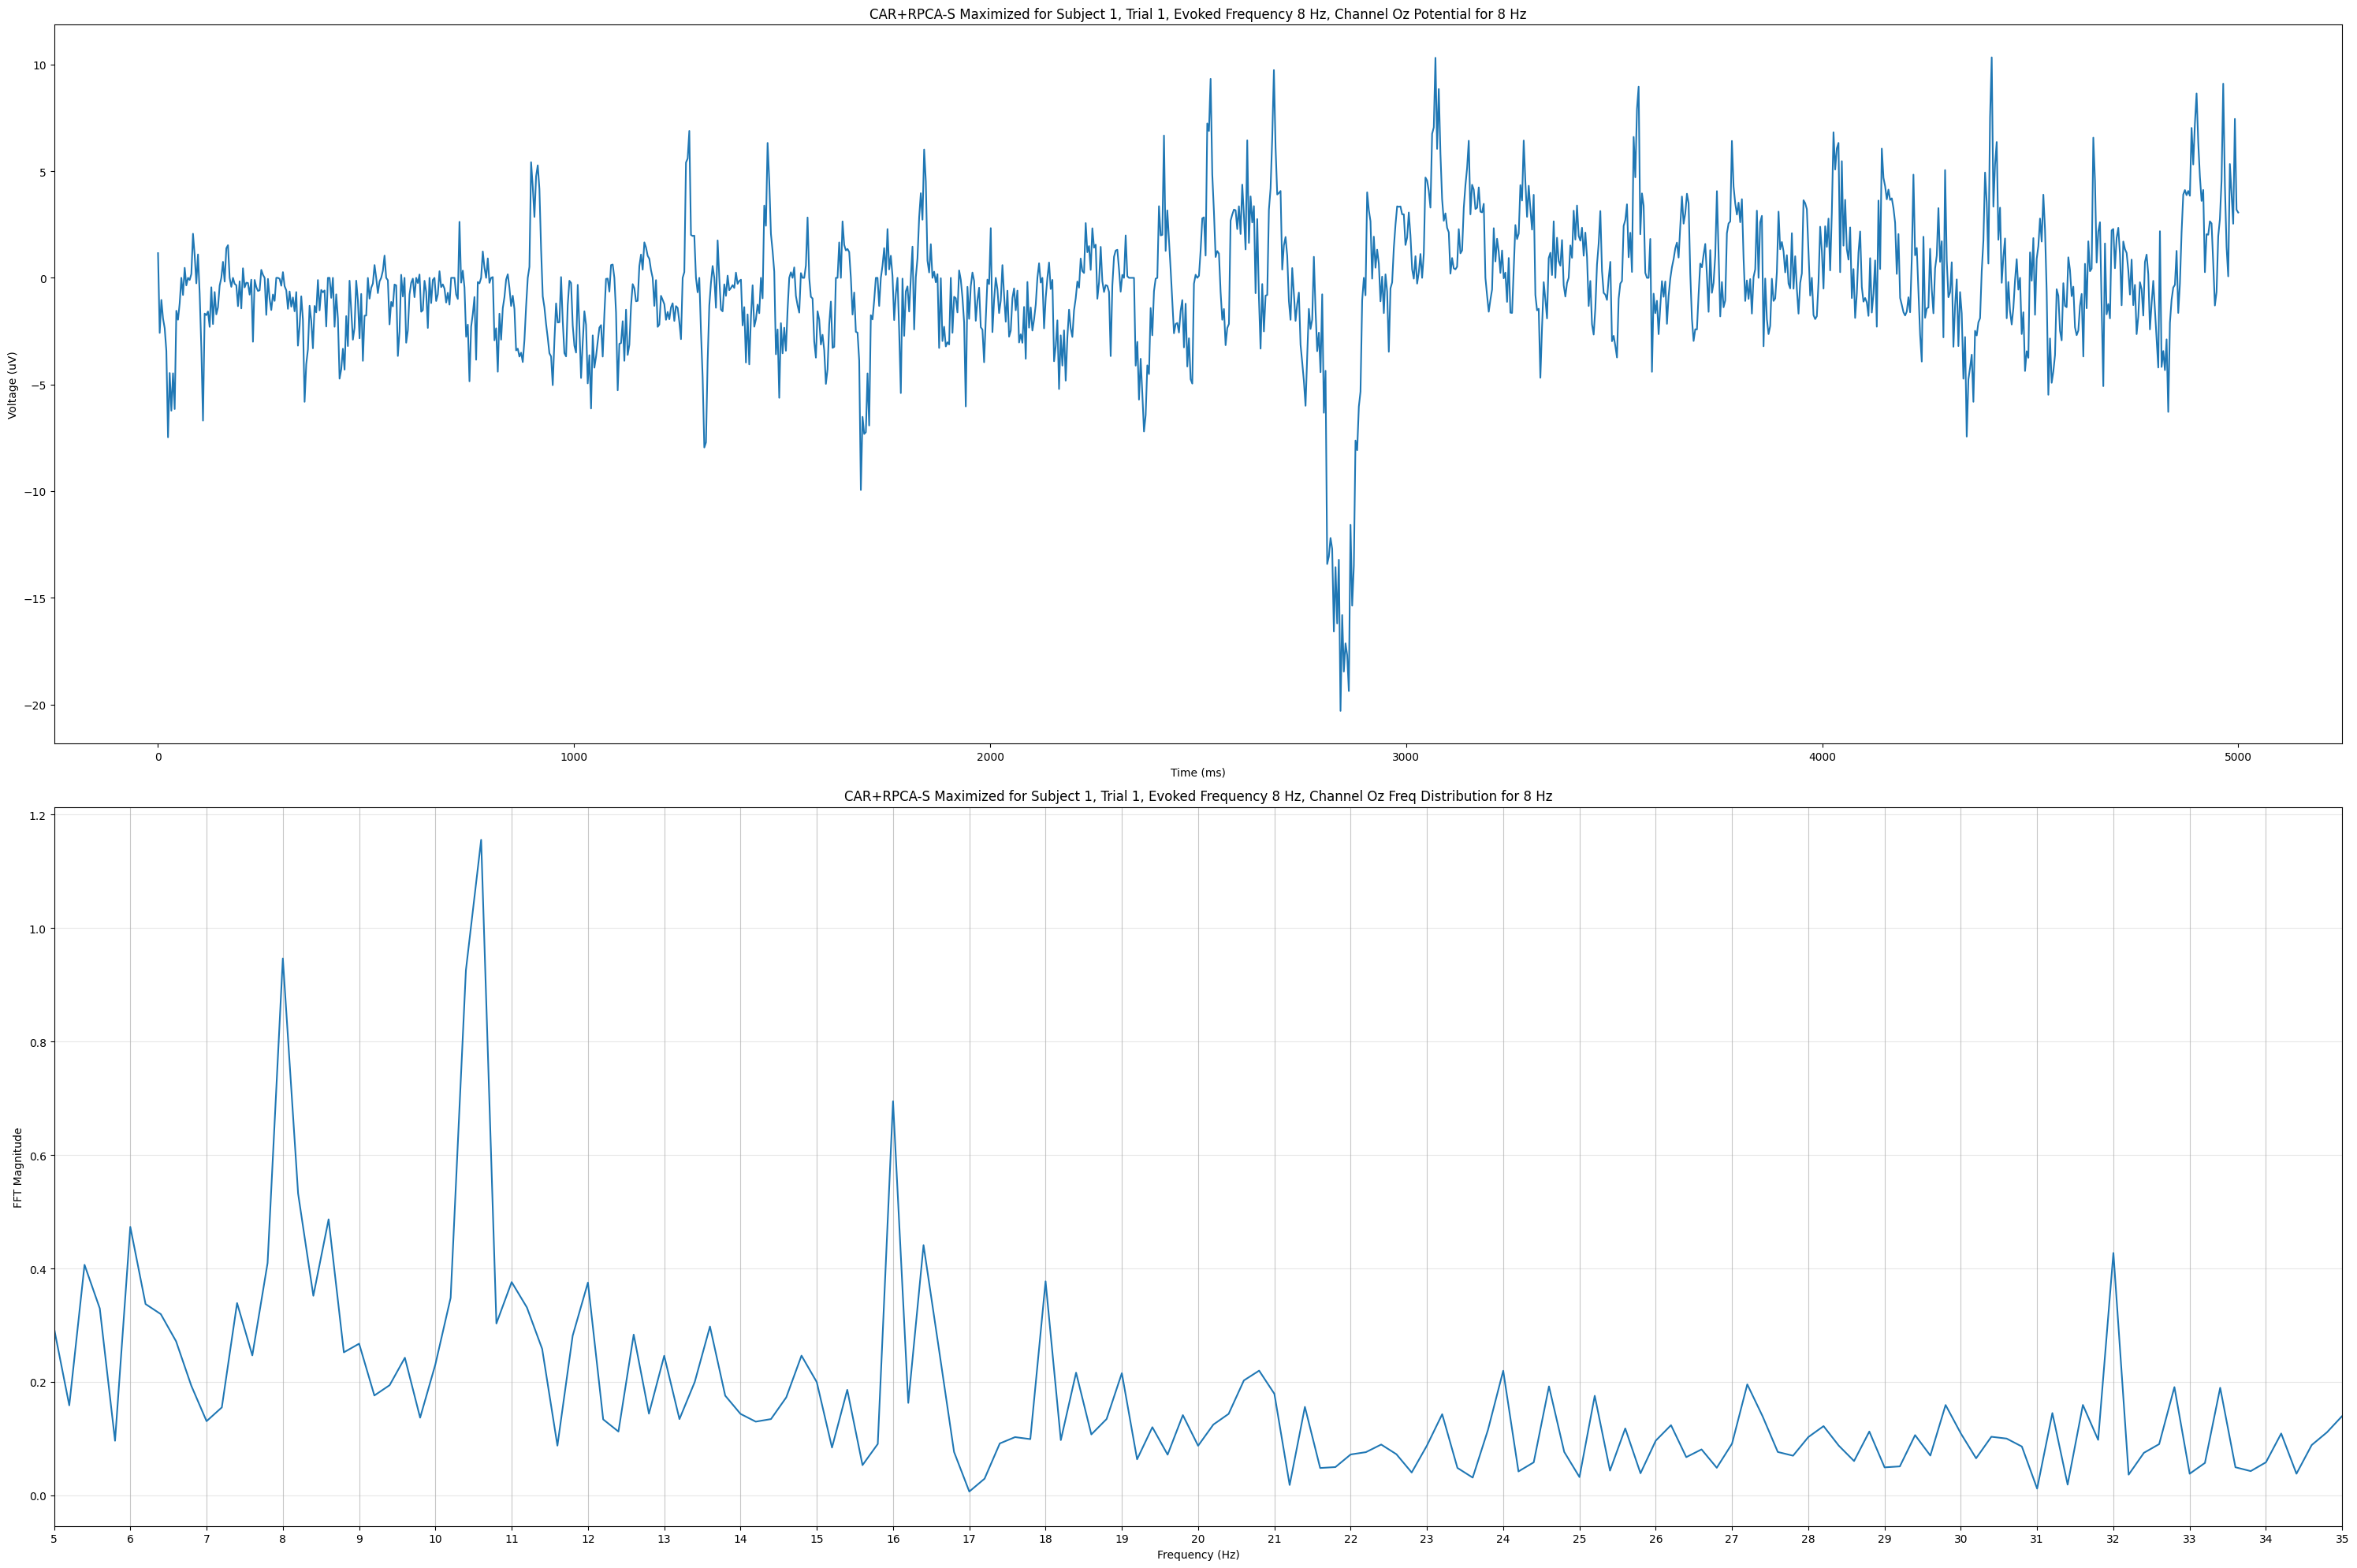

apply_rpca_filter execution time: 8.1512 seconds
RPCA decomposition time: 8.0082 seconds
Windowing time: 0.0001 seconds


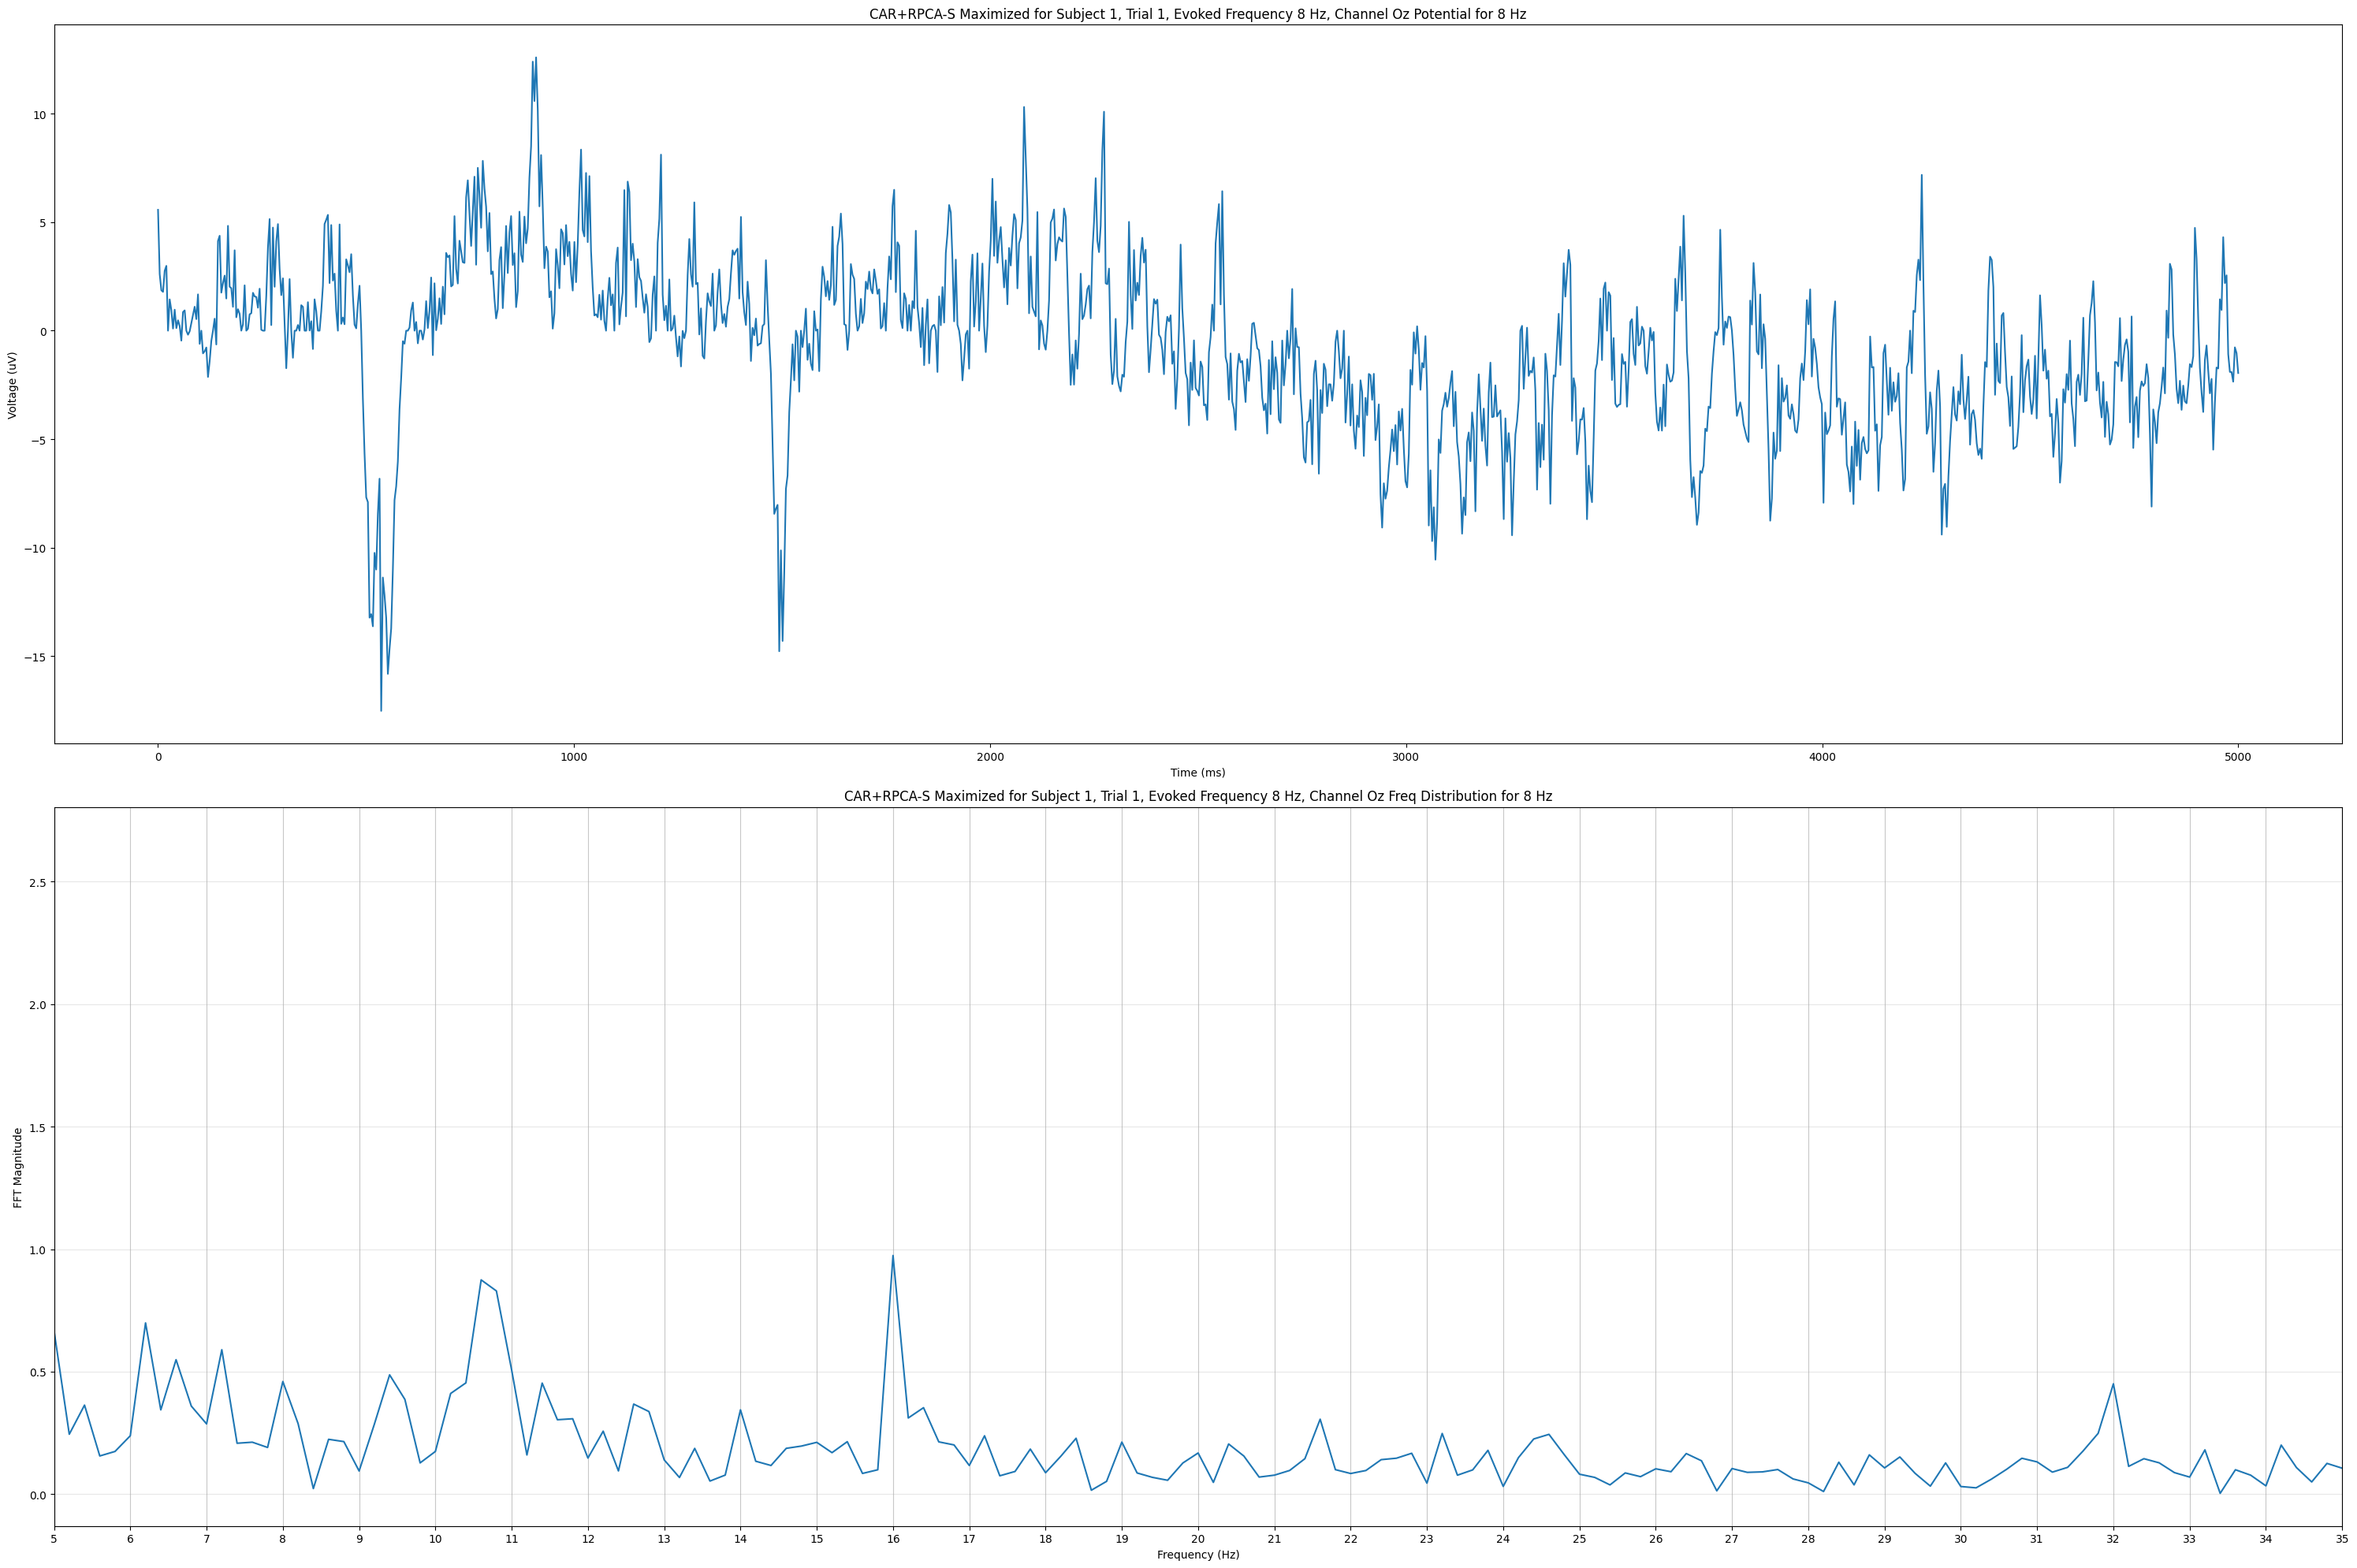

In [35]:
bci_samples = bci_end_sample - bci_start_sample
bci_time_range = np.linspace(0, bci_samples * spacing, bci_samples)
bci_freq_range = fftfreq(bci_samples, spacing)[: bci_samples // 2] * 1000

for subject in range(1, NUM_SUBJECTS+1):
    for trial in range(0, 6):
        eeg_data_filterd = apply_rpca_filter(
            apply_car_filter(eeg_data_by_subject[subject-1]),
            best_lamb_list_by_subject[subject-1][4],
            best_mu_list_by_subject[subject-1][4],
            selected_channels, bci_start_sample,
            bci_end_sample,
            evoked_frequencies
        )[1]
        # Plot the L matrix (low-frequency component)
        fig, axes = plot_time_frequency(
            data_matrix=eeg_data_filterd[:, bci_start_sample:bci_end_sample, 0, trial],
            title_prefix="CAR+RPCA-S Maximized for Subject 1, Trial 1, Evoked Frequency 8 Hz, Channel Oz",
            channels={"Oz": 61},
            time_range=bci_time_range,
            freq_range=bci_freq_range,
            frequency=evoked_frequency,
            freq_xlim=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
            figsize=(30, 20),
            show_grid=True
        )

## Feature Extraction

In [ ]:
# Create label representations for classification
# Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
Y_vector = get_label_vector(evoked_frequencies)

# Y_matrix: One-hot encoded matrix representation of labels
# (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
Y_matrix = get_label_matrix(evoked_frequencies)


In [ ]:
X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT = []

for subject in range(1, NUM_SUBJECTS+1):
    eeg_data = eeg_data_by_subject[subject - 1]

    X_LIST_BY_PREPROCESSING_METHOD = {
        "RPCA_L": None,
        "RPCA_S": None,
        "CAR_RPCA_L": None,
        "CAR_RPCA_S": None
    }

    for i, maximized_for_method in enumerate(preprocessing_methods):
        if maximized_for_method == 'CAR':
            continue
        else:
            best_lamb = best_lamb_list_by_subject[subject-1][i]
            best_mu = best_mu_list_by_subject[subject-1][i]

        # Feature extraction from CAR filtered data
        X_CAR = get_feature_matrix_from_eeg_time_domain(apply_car_filter(eeg_data), evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from RPCA low-rank component
        X_RPCA_L = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(eeg_data, best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[0], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from RPCA sparse component
        X_RPCA_S = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(eeg_data, best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[1], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from CAR+RPCA low-rank component
        X_CAR_RPCA_L = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(apply_car_filter(eeg_data), best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[0], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from CAR+RPCA sparse component
        X_CAR_RPCA_S = get_feature_matrix_from_eeg_time_domain(apply_rpca_filter(apply_car_filter(eeg_data), best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)[1], evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Make feature matrix list for all preprocessing methods
        # MUST KEEP IN THE SAME ORDER AS THE preprocessing_methods LIST
        X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]

        # Store feature matrix list for each preprocessing method
        X_LIST_BY_PREPROCESSING_METHOD[maximized_for_method] = X_LIST

    X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT.append(X_LIST_BY_PREPROCESSING_METHOD)

Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 7.1952 seconds
RPCA decomposition time: 7.1397 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 7.1593 seconds
RPCA decomposition time: 7.0892 seconds
Windowing time: 0.0000 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 6.6012 seconds
RPCA decomposition time: 6.5103 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 6.9653 seconds
RPCA decomposition time: 6.8274 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
apply_rpca_filter execution time: 0.1988 seconds
RPCA decomposition time: 0.1564 seconds
Windowing time: 0.0001 seconds
Windowed data: (5, 9, 250, 40, 6)
Featur

### Train and Validation

In [ ]:
X_training_list_by_preprocessing_method_by_subject = []
X_validation_list_by_preprocessing_method_by_subject = []
Y_vector_training_by_preprocessing_method_by_subject = []
Y_vector_validation_by_preprocessing_method_by_subject = []
Y_matrix_training_by_preprocessing_method_by_subject = []
Y_matrix_validation_by_preprocessing_method_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    # Split data into training (80%) and validation (20%) sets for each preprocessing method
    # Stratify by Y_vector to ensure balanced class distribution
    X_training_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    X_validation_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_vector_training_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_matrix_training_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_vector_validation_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_matrix_validation_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    for maximized_for_method in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1].keys():
        X_training_list = []
        X_validation_list = []
        Y_vector_training = []
        Y_vector_validation = []
        Y_matrix_training = []
        Y_matrix_validation = []

        for X in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1][maximized_for_method]:
            X_train, X_val, \
            Y_vector_train, Y_vector_val, \
            Y_matrix_train, Y_matrix_val = train_test_split(
                X,
                Y_vector,
                Y_matrix,
                test_size=0.2,
                stratify=Y_vector,
                random_state=42  # For reproducibility
            )
            
            X_training_list.append(X_train)
            X_validation_list.append(X_val)
            Y_vector_training.append(Y_vector_train)
            Y_vector_validation.append(Y_vector_val)
            Y_matrix_training.append(Y_matrix_train)
            Y_matrix_validation.append(Y_matrix_val)

        X_training_list_by_preprocessing_method[maximized_for_method] = X_training_list
        X_validation_list_by_preprocessing_method[maximized_for_method] = X_validation_list
        Y_vector_training_by_preprocessing_method[maximized_for_method] = Y_vector_training
        Y_vector_validation_by_preprocessing_method[maximized_for_method] = Y_vector_validation
        Y_matrix_training_by_preprocessing_method[maximized_for_method] = Y_matrix_training
        Y_matrix_validation_by_preprocessing_method[maximized_for_method] = Y_matrix_validation

    X_training_list_by_preprocessing_method_by_subject.append(X_training_list_by_preprocessing_method)
    X_validation_list_by_preprocessing_method_by_subject.append(X_validation_list_by_preprocessing_method)
    Y_vector_training_by_preprocessing_method_by_subject.append(Y_vector_training_by_preprocessing_method)
    Y_vector_validation_by_preprocessing_method_by_subject.append(Y_vector_validation_by_preprocessing_method)
    Y_matrix_training_by_preprocessing_method_by_subject.append(Y_matrix_training_by_preprocessing_method)
    Y_matrix_validation_by_preprocessing_method_by_subject.append(Y_matrix_validation_by_preprocessing_method)


In [ ]:
least_squares_list_by_preprocessing_method_by_subject = []
lda_list_by_preprocessing_method_by_subject = []
svm_list_by_preprocessing_method_by_subject = []
Y_least_squares_pred_list_by_preprocessing_method_by_subject = []
Y_lda_pred_list_by_preprocessing_method_by_subject = []
Y_svm_pred_list_by_preprocessing_method_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    least_squares_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    lda_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    svm_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_least_squares_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_lda_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_svm_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    for maximized_for_method in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1].keys():
        # Train models for each preprocessing method
        least_squares_list = []
        lda_list = []
        svm_list = []
        Y_least_squares_pred_list = []
        Y_lda_pred_list = []
        Y_svm_pred_list = []

        X_training_list = X_training_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        X_validation_list = X_validation_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_vector_training = Y_vector_training_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_matrix_training = Y_matrix_training_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_matrix_validation = Y_matrix_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]

        for i, method in enumerate(preprocessing_methods):
            print(f"\nTraining models for {method} preprocessing...")
            
            # Train Least Squares model
            ls = LeastSquares()
            ls.fit(X_training_list[i], Y_matrix_training[i])
            y_ls_pred = ls.predict(X_validation_list[i])
            least_squares_list.append(ls)
            Y_least_squares_pred_list.append(y_ls_pred)
            
            # Train LDA model
            lda_model = LinearDiscriminantAnalysis()
            if np.all(X_training_list[i] != 0):
                lda_model.fit(X_training_list[i], Y_vector_training[i])
                y_lda_pred = lda_model.predict(X_validation_list[i])
            else:
                y_lda_pred = np.zeros(len(X_validation_list[i]))
            lda_list.append(lda_model)
            Y_lda_pred_list.append(y_lda_pred)
            
            # Train SVM model
            svm_model = SVC(kernel='linear')
            svm_model.fit(X_training_list[i], Y_vector_training[i])
            y_svm_pred = svm_model.predict(X_validation_list[i])
            svm_list.append(svm_model)
            Y_svm_pred_list.append(y_svm_pred)

        least_squares_list_by_preprocessing_method[maximized_for_method] = least_squares_list
        lda_list_by_preprocessing_method[maximized_for_method] = lda_list
        svm_list_by_preprocessing_method[maximized_for_method] = svm_list
        Y_least_squares_pred_list_by_preprocessing_method[maximized_for_method] = Y_least_squares_pred_list
        Y_lda_pred_list_by_preprocessing_method[maximized_for_method] = Y_lda_pred_list
        Y_svm_pred_list_by_preprocessing_method[maximized_for_method] = Y_svm_pred_list
    
    least_squares_list_by_preprocessing_method_by_subject.append(least_squares_list_by_preprocessing_method)
    lda_list_by_preprocessing_method_by_subject.append(lda_list_by_preprocessing_method)
    svm_list_by_preprocessing_method_by_subject.append(svm_list_by_preprocessing_method)
    Y_least_squares_pred_list_by_preprocessing_method_by_subject.append(Y_least_squares_pred_list_by_preprocessing_method)
    Y_lda_pred_list_by_preprocessing_method_by_subject.append(Y_lda_pred_list_by_preprocessing_method)
    Y_svm_pred_list_by_preprocessing_method_by_subject.append(Y_svm_pred_list_by_preprocessing_method)



Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocess

## Result Presentation


Processing maximization for method: RPCA_L
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 17 - CAR - LS: 0.8333, LDA: 0.7917, SVM: 0.7500
Subject 18 - 

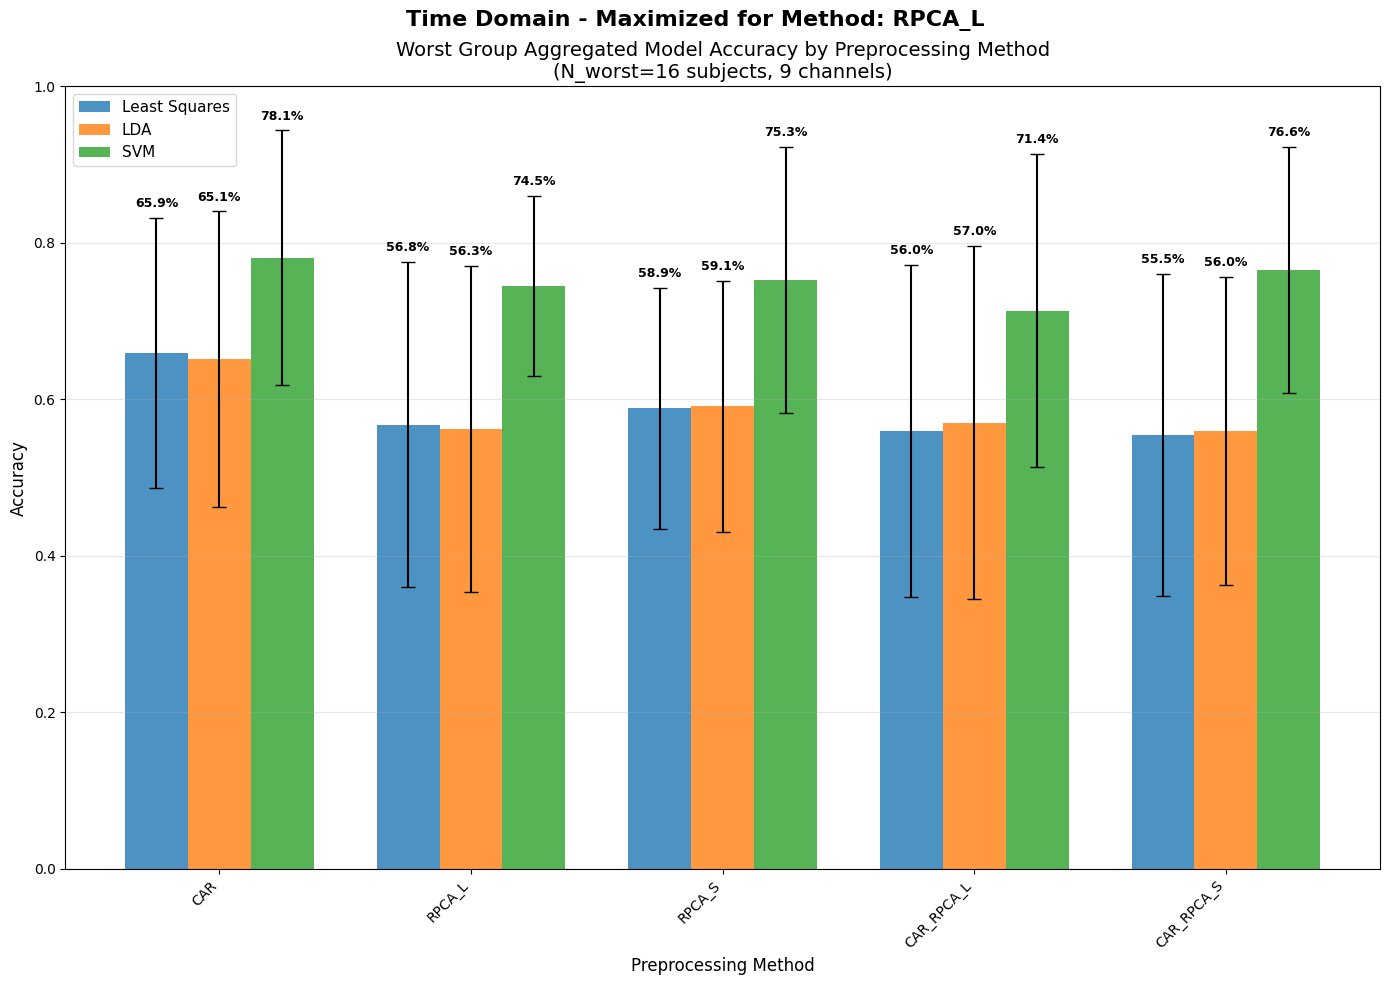

Detailed results saved to results/time_domain_aggregated_accuracies_maximized_for_RPCA_L.csv

Processing maximization for method: RPCA_S
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, L

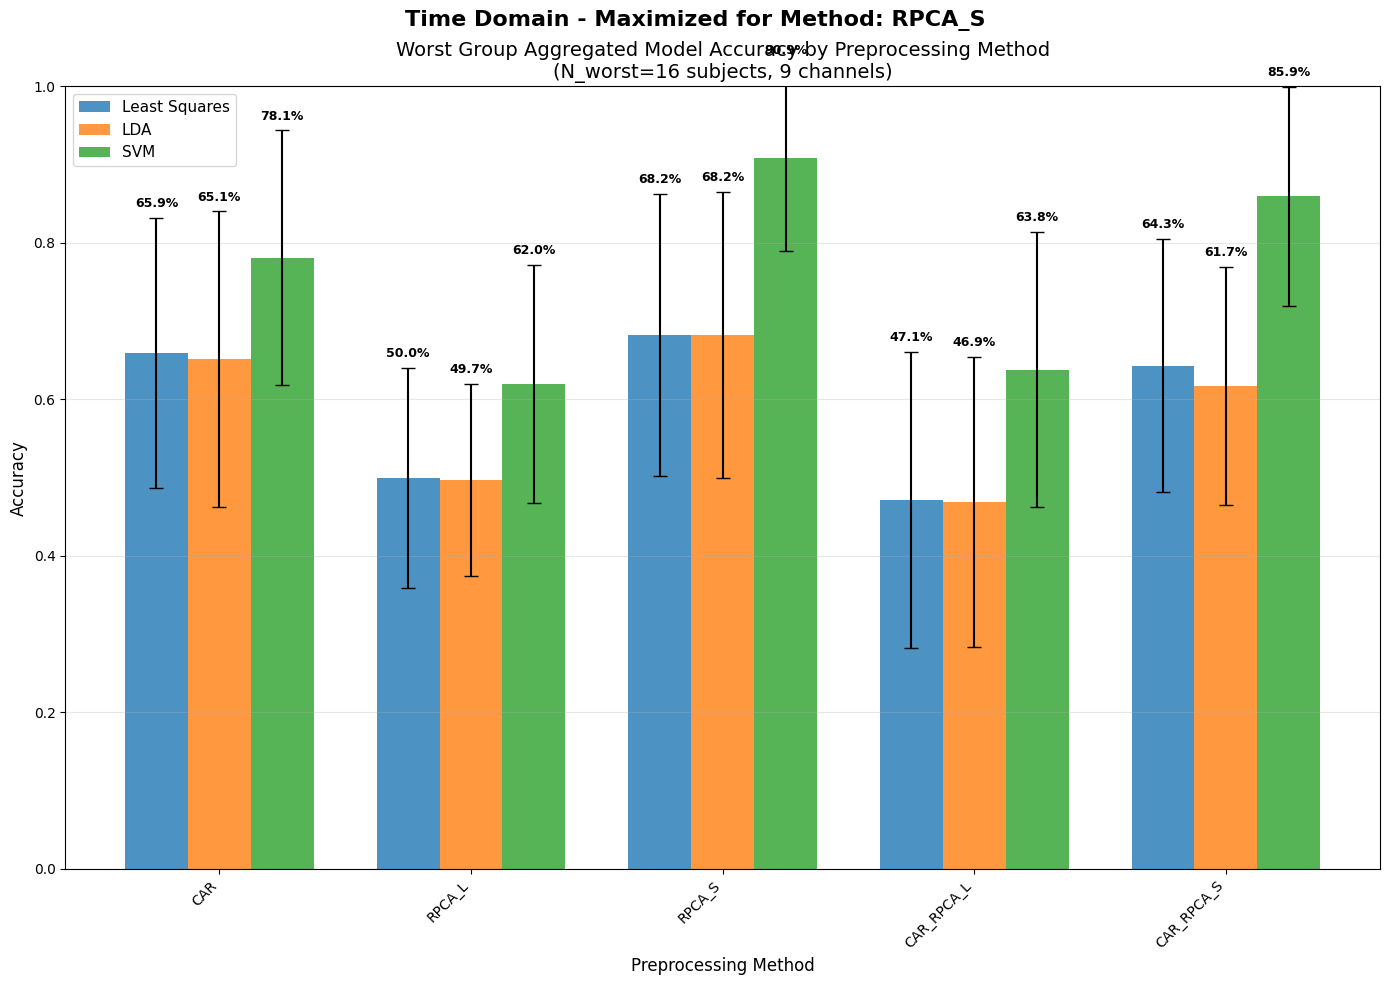

Detailed results saved to results/time_domain_aggregated_accuracies_maximized_for_RPCA_S.csv

Processing maximization for method: CAR_RPCA_L
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.750

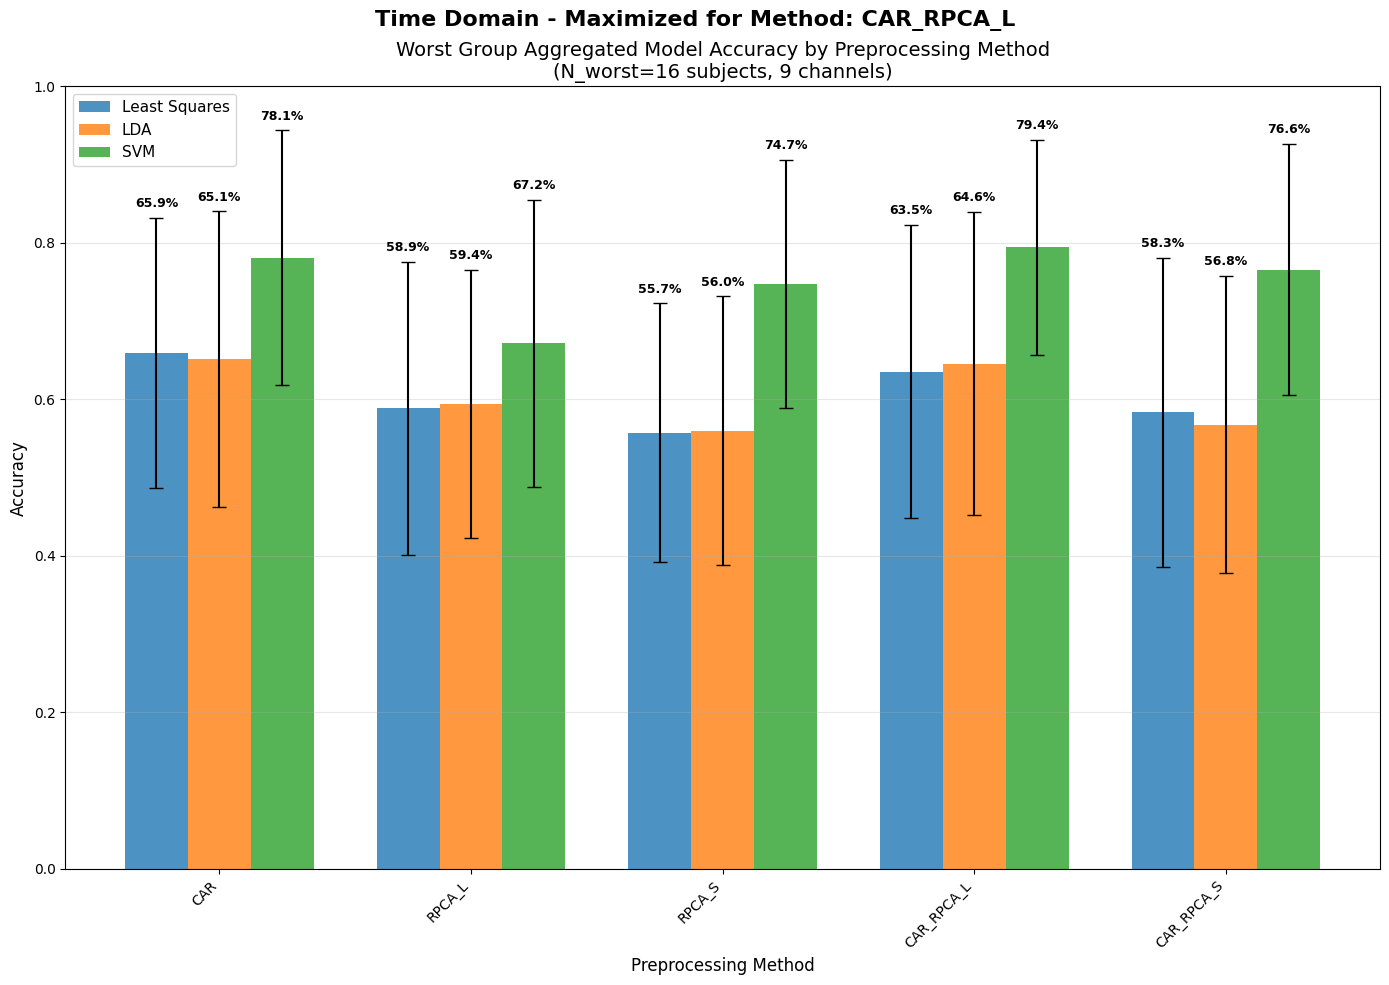

Detailed results saved to results/time_domain_aggregated_accuracies_maximized_for_CAR_RPCA_L.csv

Processing maximization for method: CAR_RPCA_S
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0

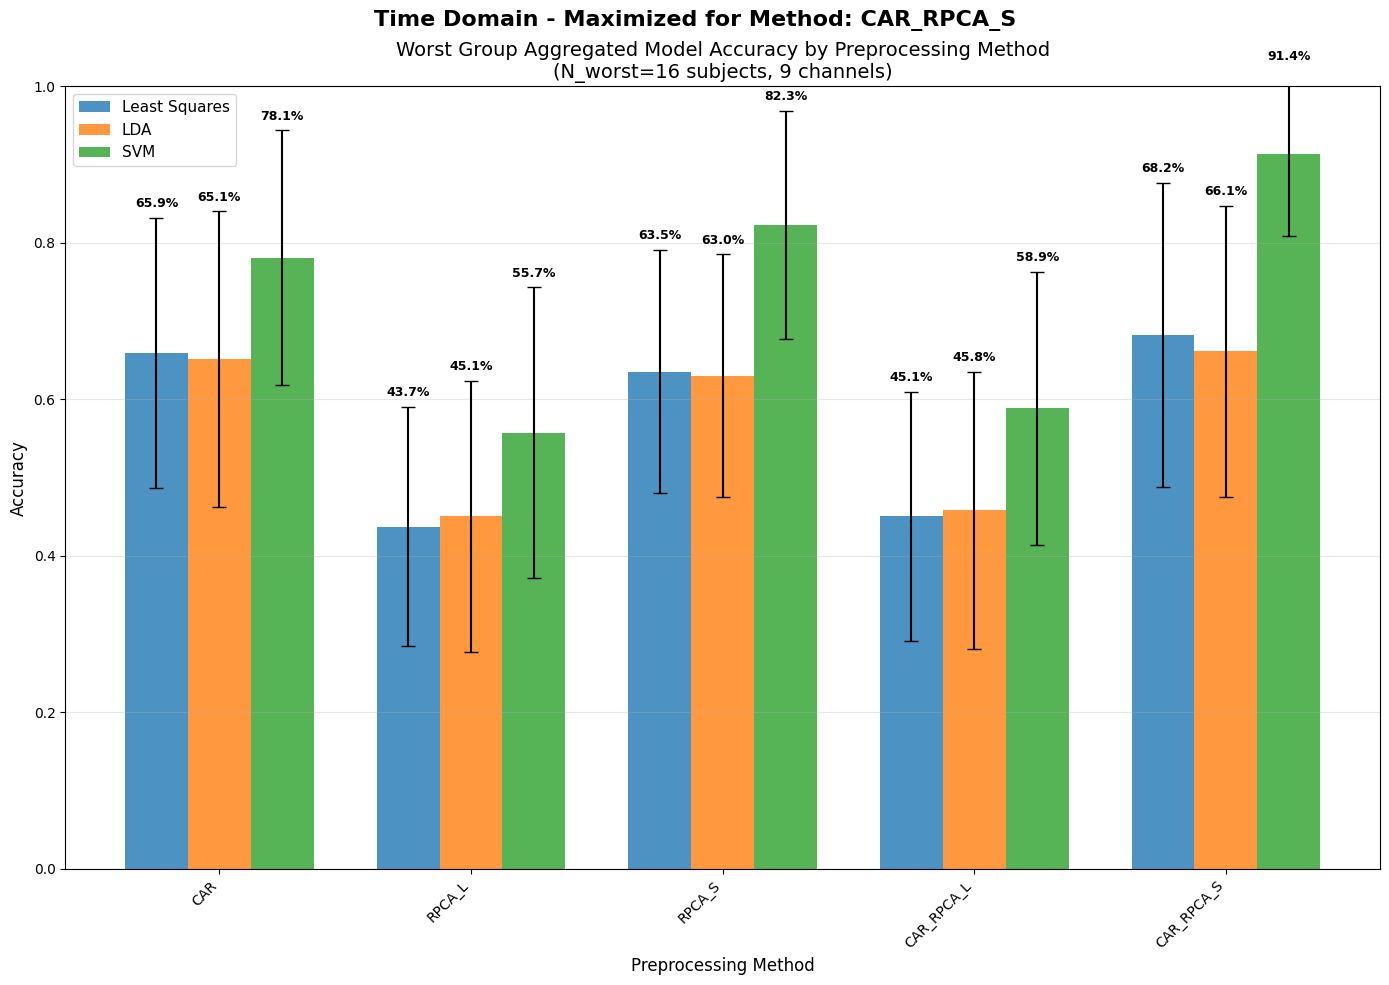

Detailed results saved to results/time_domain_aggregated_accuracies_maximized_for_CAR_RPCA_S.csv

Comprehensive results saved to results/comprehensive_worst_time_domain_aggregated_model_accuracy_by_preprocessing_method_9ch.csv

COMPREHENSIVE SUMMARY - MEAN ± STD ACCURACIES (%)
Maximized_for_Method Preprocessing_Method  LS_Mean  LS_Std  LS_Shapiro_Stat  LS_Shapiro_Pval  LS_Ttest_Stat  LS_Ttest_Pval  LS_Wilcoxon_Stat  LS_Wilcoxon_Pval  LDA_Mean  LDA_Std  LDA_Shapiro_Stat  LDA_Shapiro_Pval  LDA_Ttest_Stat  LDA_Ttest_Pval  LDA_Wilcoxon_Stat  LDA_Wilcoxon_Pval  SVM_Mean  SVM_Std  SVM_Shapiro_Stat  SVM_Shapiro_Pval  SVM_Ttest_Stat  SVM_Ttest_Pval  SVM_Wilcoxon_Stat  SVM_Wilcoxon_Pval  Num_Subjects
              RPCA_L                  CAR    65.89   17.26             0.80             0.00            NaN            NaN               NaN               NaN     65.10    18.92              0.91              0.14             NaN             NaN                NaN                NaN     78.13    16

In [ ]:
from scipy.stats import shapiro, ttest_rel, wilcoxon
# Perform paired t-tests and Wilcoxon comparing each method against the first one (baseline)
def compare_against_baseline(accuracies_array):
    """Compare each preprocessing method against the first one (baseline) using paired t-test and Wilcoxon signed-rank test"""
    baseline = accuracies_array[:, 0]  # First preprocessing method as baseline
    ttest_stats = []
    ttest_pvals = []
    wilcoxon_stats = []
    wilcoxon_pvals = []

    for i in range(accuracies_array.shape[1]):
        if i == 0:
            # Baseline vs itself - no test needed
            ttest_stats.append(np.nan)
            ttest_pvals.append(np.nan)
            wilcoxon_stats.append(np.nan)
            wilcoxon_pvals.append(np.nan)
        else:
            # Compare each method against baseline (paired t-test)
            stat, pval = ttest_rel(baseline, accuracies_array[:, i])
            ttest_stats.append(stat)
            ttest_pvals.append(pval)

            # Wilcoxon signed-rank test
            try:
                w_stat, w_pval = wilcoxon(baseline, accuracies_array[:, i])
            except ValueError:
                # Wilcoxon fails if all differences are zero
                w_stat, w_pval = np.nan, np.nan
            wilcoxon_stats.append(w_stat)
            wilcoxon_pvals.append(w_pval)

    return {
        "ttest_stats": np.array(ttest_stats),
        "ttest_pvals": np.array(ttest_pvals),
        "wilcoxon_stats": np.array(wilcoxon_stats),
        "wilcoxon_pvals": np.array(wilcoxon_pvals)
    }

def store_accuracies():
    subjects_ls_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    subjects_lda_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    subjects_svm_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    # Process all subjects for each maximization method
    for i, maximized_for_method in enumerate(["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]):
        print(f"\nProcessing maximization for method: {maximized_for_method}")
        
        # Collect accuracies for all subjects
        subjects_ls_accuracies = []  # [subject][preprocessing_method]
        subjects_lda_accuracies = []
        subjects_svm_accuracies = []
        
        # Process each subject (data is organized by subject, then by preprocessing method)
        for subject in range(1, NUM_SUBJECTS+1):
            try:
                # Get validation data for this subject and maximized method
                # The data structure is: by_subject[subject-1][preprocessing_method][list_index]
                Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                
                # Calculate accuracies for each preprocessing method for this subject
                subject_ls_accs = []
                subject_lda_accs = []
                subject_svm_accs = []
                
                for j, method in enumerate(preprocessing_methods):
                    ls_acc = accuracy_score(Y_vector_validation[j], Y_least_squares_pred_list[j])
                    lda_acc = accuracy_score(Y_vector_validation[j], Y_lda_pred_list[j])
                    svm_acc = accuracy_score(Y_vector_validation[j], Y_svm_pred_list[j])
                    
                    subject_ls_accs.append(ls_acc)
                    subject_lda_accs.append(lda_acc)
                    subject_svm_accs.append(svm_acc)

                    if method == 'CAR':
                        print(f"Subject {subject} - {method} - LS: {ls_acc:.4f}, LDA: {lda_acc:.4f}, SVM: {svm_acc:.4f}")
                
                subjects_ls_accuracies.append(subject_ls_accs)
                subjects_lda_accuracies.append(subject_lda_accs)
                subjects_svm_accuracies.append(subject_svm_accs)
                
            except (IndexError, KeyError) as e:
                print(f"Warning: Could not process subject {subject} for method {maximized_for_method}: {e}")
                continue
        
        subjects_ls_accuracies_by_preprocessing_method[maximized_for_method] = subjects_ls_accuracies
        subjects_lda_accuracies_by_preprocessing_method[maximized_for_method] = subjects_lda_accuracies
        subjects_svm_accuracies_by_preprocessing_method[maximized_for_method] = subjects_svm_accuracies

    subjects_all_accuracies_by_preprocessing_method = {
        "Least Squares": subjects_ls_accuracies_by_preprocessing_method,
        "LDA": subjects_lda_accuracies_by_preprocessing_method,
        "SVM": subjects_svm_accuracies_by_preprocessing_method
    }
    pd.DataFrame(subjects_all_accuracies_by_preprocessing_method).to_csv('results/subjects_all_accuracies_by_preprocessing_method_time.csv', index=False)

def generate_boxplot():
    # -----------------------------------------
    # Unified matplotlib boxplot for all classifiers and preprocessing methods
    # -----------------------------------------

    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    # Data layout: preprocessing_methods x classifiers x subjects
    data = [
        subjects_ls_accuracies,   # shape: subjects x methods
        subjects_lda_accuracies,
        subjects_svm_accuracies
    ]  # List of [subjects x methods] arrays

    classifier_names = ['Least Squares', 'LDA', 'SVM']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # For LS, LDA, SVM

    num_methods = len(preprocessing_methods)
    num_classifiers = len(classifier_names)

    fig, ax = plt.subplots(figsize=(16,8))

    box_width = 0.22
    box_distance = 0.08
    total_width = num_classifiers * box_width + (num_classifiers-1)*box_distance
    xs = np.arange(num_methods)

    # Collect boxplot positions and data
    boxplot_data = []
    positions = []
    color_patches = []

    for i, method in enumerate(preprocessing_methods):
        for j, (clf_accs, clf_name) in enumerate(zip(data, classifier_names)):
            # For each classifier for this method, get accuracy for all subjects (the column)
            boxplot_data.append(clf_accs[:,i])
            # Position: spaced within each group
            pos = i - total_width/2 + box_width/2 + j*(box_width+box_distance)
            positions.append(pos)
            if i == 0:
                color_patches.append(mpatches.Patch(color=colors[j], label=clf_name))

    # Draw single combined boxplot using matplotlib
    bp = ax.boxplot(
        boxplot_data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        showfliers=True
    )

    # Color the boxes
    for k, box in enumerate(bp['boxes']):
        classifier_idx = k % num_classifiers
        box.set(facecolor=colors[classifier_idx], alpha=0.7)
    for k, median in enumerate(bp['medians']):
        median.set(color='black', linewidth=2)
    for k, mean in enumerate(bp['means']):
        mean.set(color='red', linewidth=2)
    for k, whisker in enumerate(bp['whiskers']):
        whisker.set(color='grey')
    for k, cap in enumerate(bp['caps']):
        cap.set(color='grey')

    # X-axis: Set ticks at center of each group
    ax.set_xticks(xs)
    ax.set_xticklabels(preprocessing_methods, rotation=45, ha='right', fontsize=12)

    # Y-label and title
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Preprocessing Method', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.2)

    # Main title and subtitle
    ax.set_title(
        f"Accuracy Distribution by Classifier and Preprocessing Method"
        f"\n(N={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels, Maximized: {maximized_for_method})",
        fontsize=15, fontweight='bold'
    )

    # Legends for classifier colors, means, and medians
    handles = color_patches.copy()
    # Add legend for mean (red line) and median (black line)
    mean_line = mlines.Line2D([], [], color='red', linewidth=2, label='Mean')
    median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
    handles.extend([mean_line, median_line])

    ax.legend(handles=handles, fontsize=12)
    plt.tight_layout()

    # Save
    plt.savefig(
        f'results/frequency_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png', 
        dpi=300, bbox_inches='tight'
    )
    print(f"Unified boxplot saved to: results/frequency_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png")
    plt.show()
    # -----------------------------------------


# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)
store_accuracies()

# Initialize storage for aggregated results across all subjects
aggregated_results = {}

# Initialize a structure to collect all accuracies across subjects
for preprocessing_method in ["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]:
    aggregated_results[preprocessing_method] = {
        'ls_accuracies': [],  # Will be 2D: [subject][preprocessing_method]
        'lda_accuracies': [],
        'svm_accuracies': [],
        'preprocessing_methods': preprocessing_methods.copy()
    }

selected_subjects_type = "worst"

selected_subjects = {
    "best": [0, 2, 5, 7, 9, 13, 14, 16, 19, 21, 24, 25, 26, 27, 29, 30, 31, 33, 34],
    "worst": [1, 3, 4, 6, 8, 10, 11, 12, 15, 17, 18, 20, 22, 23, 28, 32],
    "all": list(range(NUM_SUBJECTS))
}

selected_plot_title = {
    "best": f'Best Group Aggregated Model Accuracy by Preprocessing Method\n(N_best={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)',
    "worst": f'Worst Group Aggregated Model Accuracy by Preprocessing Method\n(N_worst={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)',
    "all": f'Aggregated Model Accuracy by Preprocessing Method\n(N={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)'
}

selected_file_name = {
    "best": f'best_time_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch',
    "worst": f'worst_time_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch',
    "all": f'time_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch'
}

# Process all subjects for each maximization method
for i, maximized_for_method in enumerate(["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]):
    print(f"\nProcessing maximization for method: {maximized_for_method}")
    
    # Collect accuracies for all subjects
    subjects_ls_accuracies = []  # [subject][preprocessing_method]
    subjects_lda_accuracies = []
    subjects_svm_accuracies = []
    
    # Process each subject (data is organized by subject, then by preprocessing method)
    for subject in range(1, NUM_SUBJECTS+1):
        try:
            # Get validation data for this subject and maximized method
            # The data structure is: by_subject[subject-1][preprocessing_method][list_index]
            Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            
            # Calculate accuracies for each preprocessing method for this subject
            subject_ls_accs = []
            subject_lda_accs = []
            subject_svm_accs = []
            
            for j, method in enumerate(preprocessing_methods):
                ls_acc = accuracy_score(Y_vector_validation[j], Y_least_squares_pred_list[j])
                lda_acc = accuracy_score(Y_vector_validation[j], Y_lda_pred_list[j])
                svm_acc = accuracy_score(Y_vector_validation[j], Y_svm_pred_list[j])
                
                subject_ls_accs.append(ls_acc)
                subject_lda_accs.append(lda_acc)
                subject_svm_accs.append(svm_acc)

                if method == 'CAR':
                    print(f"Subject {subject} - {method} - LS: {ls_acc:.4f}, LDA: {lda_acc:.4f}, SVM: {svm_acc:.4f}")
            
            subjects_ls_accuracies.append(subject_ls_accs)
            subjects_lda_accuracies.append(subject_lda_accs)
            subjects_svm_accuracies.append(subject_svm_accs)
            
        except (IndexError, KeyError) as e:
            print(f"Warning: Could not process subject {subject} for method {maximized_for_method}: {e}")
            continue
    
    # Convert to numpy arrays for easier computation
    subjects_ls_accuracies = np.array(subjects_ls_accuracies)
    subjects_lda_accuracies = np.array(subjects_lda_accuracies)
    subjects_svm_accuracies = np.array(subjects_svm_accuracies)
    
    subjects_ls_accuracies = subjects_ls_accuracies[selected_subjects[selected_subjects_type]]
    subjects_lda_accuracies = subjects_lda_accuracies[selected_subjects[selected_subjects_type]]
    subjects_svm_accuracies = subjects_svm_accuracies[selected_subjects[selected_subjects_type]]

    # Calculate mean and std across subjects for each preprocessing method
    ls_mean = np.mean(subjects_ls_accuracies, axis=0)
    ls_std = np.std(subjects_ls_accuracies, axis=0)
    ls_shapiro = shapiro(subjects_ls_accuracies, axis=0)
    lda_mean = np.mean(subjects_lda_accuracies, axis=0)
    lda_std = np.std(subjects_lda_accuracies, axis=0)
    lda_shapiro = shapiro(subjects_lda_accuracies, axis=0)
    svm_mean = np.mean(subjects_svm_accuracies, axis=0)
    svm_std = np.std(subjects_svm_accuracies, axis=0)
    svm_shapiro = shapiro(subjects_svm_accuracies, axis=0)

    # Store aggregated results
    aggregated_results[maximized_for_method]['ls_mean'] = ls_mean
    aggregated_results[maximized_for_method]['ls_std'] = ls_std
    aggregated_results[maximized_for_method]['ls_shapiro_stat'] = ls_shapiro[0]
    aggregated_results[maximized_for_method]['ls_shapiro_pval'] = ls_shapiro[1]
    aggregated_results[maximized_for_method]['ls_ttest_stat'] = compare_against_baseline(subjects_ls_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['ls_ttest_pval'] = compare_against_baseline(subjects_ls_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['ls_wilcoxon_stat'] = compare_against_baseline(subjects_ls_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['ls_wilcoxon_pval'] = compare_against_baseline(subjects_ls_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['lda_mean'] = lda_mean
    aggregated_results[maximized_for_method]['lda_std'] = lda_std
    aggregated_results[maximized_for_method]['lda_shapiro_stat'] = lda_shapiro[0]
    aggregated_results[maximized_for_method]['lda_shapiro_pval'] = lda_shapiro[1]
    aggregated_results[maximized_for_method]['lda_ttest_stat'] = compare_against_baseline(subjects_lda_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['lda_ttest_pval'] = compare_against_baseline(subjects_lda_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['lda_wilcoxon_stat'] = compare_against_baseline(subjects_lda_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['lda_wilcoxon_pval'] = compare_against_baseline(subjects_lda_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['svm_mean'] = svm_mean
    aggregated_results[maximized_for_method]['svm_std'] = svm_std
    aggregated_results[maximized_for_method]['svm_shapiro_stat'] = svm_shapiro[0]
    aggregated_results[maximized_for_method]['svm_shapiro_pval'] = svm_shapiro[1]
    aggregated_results[maximized_for_method]['svm_ttest_stat'] = compare_against_baseline(subjects_svm_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['svm_ttest_pval'] = compare_against_baseline(subjects_svm_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['svm_wilcoxon_stat'] = compare_against_baseline(subjects_svm_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['svm_wilcoxon_pval'] = compare_against_baseline(subjects_svm_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['num_subjects'] = len(subjects_ls_accuracies)
    
    # Print summary statistics
    print(f"\nSummary for {maximized_for_method} (N={len(subjects_ls_accuracies)} subjects):")
    for j, method in enumerate(preprocessing_methods):
        print(f"{method}:")
        print(f"  LS: {ls_mean[j]*100:.2f}% ± {ls_std[j]*100:.2f}%")
        print(f"  LDA: {lda_mean[j]*100:.2f}% ± {lda_std[j]*100:.2f}%")
        print(f"  SVM: {svm_mean[j]*100:.2f}% ± {svm_std[j]*100:.2f}%")
    
    # Create aggregated bar chart with error bars
    plt.figure(figsize=(14, 10))
    x = np.arange(len(preprocessing_methods))
    width = 0.25
    
    # Create bars with error bars
    bars_ls = plt.bar(x - width, ls_mean, width, yerr=ls_std, 
                     label='Least Squares', capsize=5, alpha=0.8)
    bars_lda = plt.bar(x, lda_mean, width, yerr=lda_std, 
                      label='LDA', capsize=5, alpha=0.8)
    bars_svm = plt.bar(x + width, svm_mean, width, yerr=svm_std, 
                      label='SVM', capsize=5, alpha=0.8)
    
    # Add mean values above each bar
    for idx, bar in enumerate(bars_ls):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + ls_std[idx] + 0.01, 
                f"{ls_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_lda):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + lda_std[idx] + 0.01, 
                f"{lda_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_svm):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + svm_std[idx] + 0.01, 
                f"{svm_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.xlabel('Preprocessing Method', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(selected_plot_title[selected_subjects_type], fontsize=14)
    plt.suptitle(f'Time Domain - Maximized for Method: {maximized_for_method}', fontsize=16, fontweight='bold')
    plt.xticks(x, preprocessing_methods, rotation=45, ha='right')
    plt.ylim(0, min(1.0, np.max([ls_mean + ls_std, lda_mean + lda_std, svm_mean + svm_std]) + 0.1))
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{selected_file_name[selected_subjects_type]}_maximized_for_{maximized_for_method}.png', 
                dpi=300, bbox_inches='tight')
    print(f"Aggregated accuracy chart saved to results/{selected_file_name[selected_subjects_type]}_maximized_for_{maximized_for_method}.png")
    
    # Display the bar plot
    plt.show()

    # Create detailed results DataFrame for this maximization method
    detailed_results = []
    for j, method in enumerate(preprocessing_methods):
        detailed_results.append({
            'Maximized_for_Method': maximized_for_method,
            'Preprocessing_Method': method,
            'LS_Mean': ls_mean[j] * 100,
            'LS_Std': ls_std[j] * 100,
            'LS_Shapiro_Stat': ls_shapiro[0][j],
            'LS_Shapiro_Pval': ls_shapiro[1][j],
            'LS_Ttest_Stat': compare_against_baseline(subjects_ls_accuracies)['ttest_stats'][j],
            'LS_Ttest_Pval': compare_against_baseline(subjects_ls_accuracies)['ttest_pvals'][j],
            'LS_Wilcoxon_Stat': compare_against_baseline(subjects_ls_accuracies)['wilcoxon_stats'][j],
            'LS_Wilcoxon_Pval': compare_against_baseline(subjects_ls_accuracies)['wilcoxon_pvals'][j],
            'LDA_Mean': lda_mean[j] * 100,
            'LDA_Std': lda_std[j] * 100,
            'LDA_Shapiro_Stat': lda_shapiro[0][j],
            'LDA_Shapiro_Pval': lda_shapiro[1][j],
            'LDA_Ttest_Stat': compare_against_baseline(subjects_lda_accuracies)['ttest_stats'][j],
            'LDA_Ttest_Pval': compare_against_baseline(subjects_lda_accuracies)['ttest_pvals'][j],
            'LDA_Wilcoxon_Stat': compare_against_baseline(subjects_lda_accuracies)['wilcoxon_stats'][j],
            'LDA_Wilcoxon_Pval': compare_against_baseline(subjects_lda_accuracies)['wilcoxon_pvals'][j],
            'SVM_Mean': svm_mean[j] * 100,
            'SVM_Std': svm_std[j] * 100,
            'SVM_Shapiro_Stat': svm_shapiro[0][j],
            'SVM_Shapiro_Pval': svm_shapiro[1][j],
            'SVM_Ttest_Stat': compare_against_baseline(subjects_svm_accuracies)['ttest_stats'][j],
            'SVM_Ttest_Pval': compare_against_baseline(subjects_svm_accuracies)['ttest_pvals'][j],
            'SVM_Wilcoxon_Stat': compare_against_baseline(subjects_svm_accuracies)['wilcoxon_stats'][j],
            'SVM_Wilcoxon_Pval': compare_against_baseline(subjects_svm_accuracies)['wilcoxon_pvals'][j],
            'Num_Subjects': len(subjects_ls_accuracies)
        })
    
    # Save detailed results to CSV for this maximization method
    detailed_df = pd.DataFrame(detailed_results)
    csv_filename = f'results/time_domain_aggregated_accuracies_maximized_for_{maximized_for_method}.csv'
    detailed_df.to_csv(csv_filename, index=False)
    print(f"Detailed results saved to {csv_filename}")

# Create a comprehensive summary DataFrame combining all maximization methods
all_results = []
for maximized_method, results in aggregated_results.items():
    if 'ls_mean' in results:  # Check if processing was successful
        for j, preprocessing_method in enumerate(results['preprocessing_methods']):
            all_results.append({
                'Maximized_for_Method': maximized_method,
                'Preprocessing_Method': preprocessing_method,
                'LS_Mean': results['ls_mean'][j] * 100,
                'LS_Std': results['ls_std'][j] * 100,
                'LS_Shapiro_Stat': results['ls_shapiro_stat'][j],
                'LS_Shapiro_Pval': results['ls_shapiro_pval'][j],
                'LS_Ttest_Stat': results['ls_ttest_stat'][j],
                'LS_Ttest_Pval': results['ls_ttest_pval'][j],
                'LS_Wilcoxon_Stat': results['ls_wilcoxon_stat'][j],
                'LS_Wilcoxon_Pval': results['ls_wilcoxon_pval'][j],
                'LDA_Mean': results['lda_mean'][j] * 100,
                'LDA_Std': results['lda_std'][j] * 100,
                'LDA_Shapiro_Stat': results['lda_shapiro_stat'][j],
                'LDA_Shapiro_Pval': results['lda_shapiro_pval'][j],
                'LDA_Ttest_Stat': results['lda_ttest_stat'][j],
                'LDA_Ttest_Pval': results['lda_ttest_pval'][j],
                'LDA_Wilcoxon_Stat': results['lda_wilcoxon_stat'][j],
                'LDA_Wilcoxon_Pval': results['lda_wilcoxon_pval'][j],
                'SVM_Mean': results['svm_mean'][j] * 100,
                'SVM_Std': results['svm_std'][j] * 100,
                'SVM_Shapiro_Stat': results['svm_shapiro_stat'][j],
                'SVM_Shapiro_Pval': results['svm_shapiro_pval'][j],
                'SVM_Ttest_Stat': results['svm_ttest_stat'][j],
                'SVM_Ttest_Pval': results['svm_ttest_pval'][j],
                'SVM_Wilcoxon_Stat': results['svm_wilcoxon_stat'][j],
                'SVM_Wilcoxon_Pval': results['svm_wilcoxon_pval'][j],
                'Num_Subjects': results['num_subjects']
            })

# Save comprehensive results
if all_results:
    comprehensive_df = pd.DataFrame(all_results)
    comprehensive_df.to_csv(f'results/comprehensive_{selected_file_name[selected_subjects_type]}.csv', index=False)
    print(f"\nComprehensive results saved to results/comprehensive_{selected_file_name[selected_subjects_type]}.csv")
    
    # Display summary table
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY - MEAN ± STD ACCURACIES (%)")
    print("="*100)
    print(comprehensive_df.to_string(index=False, float_format='%.2f'))

print(f"\n✅ Processing complete! Generated aggregated results for all maximization methods.")



Processing maximization for method: RPCA_L
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 17 - CAR - LS: 0.8333, LDA: 0.7917, SVM: 0.7500
Subject 18 - 

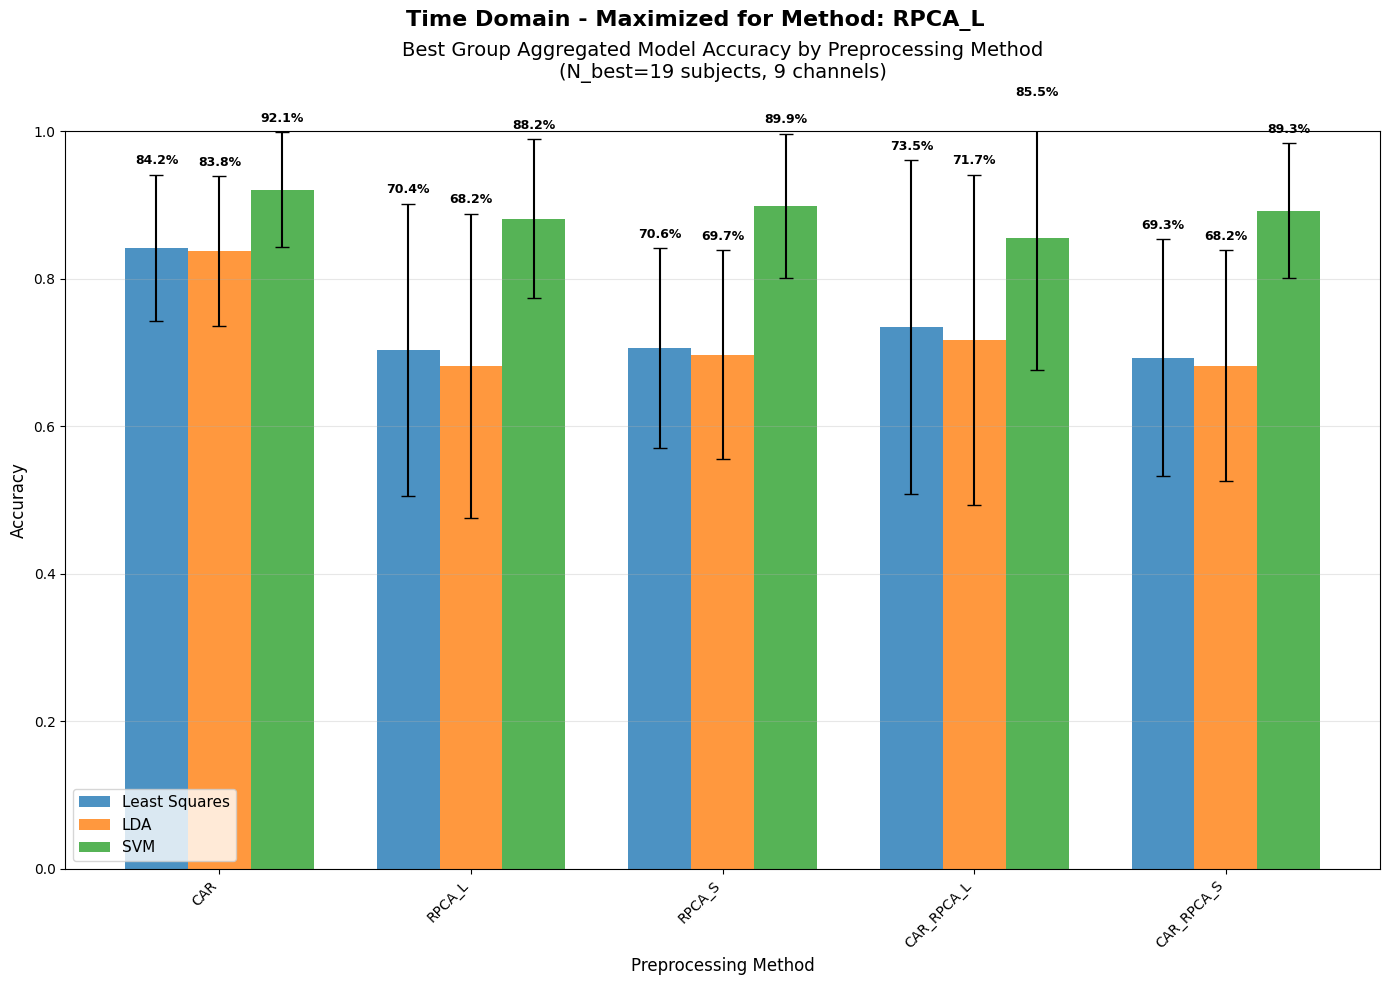

Unified boxplot saved to: results/best_time_domain_domain_unified_boxplot_9ch_maximized_for_RPCA_L.png


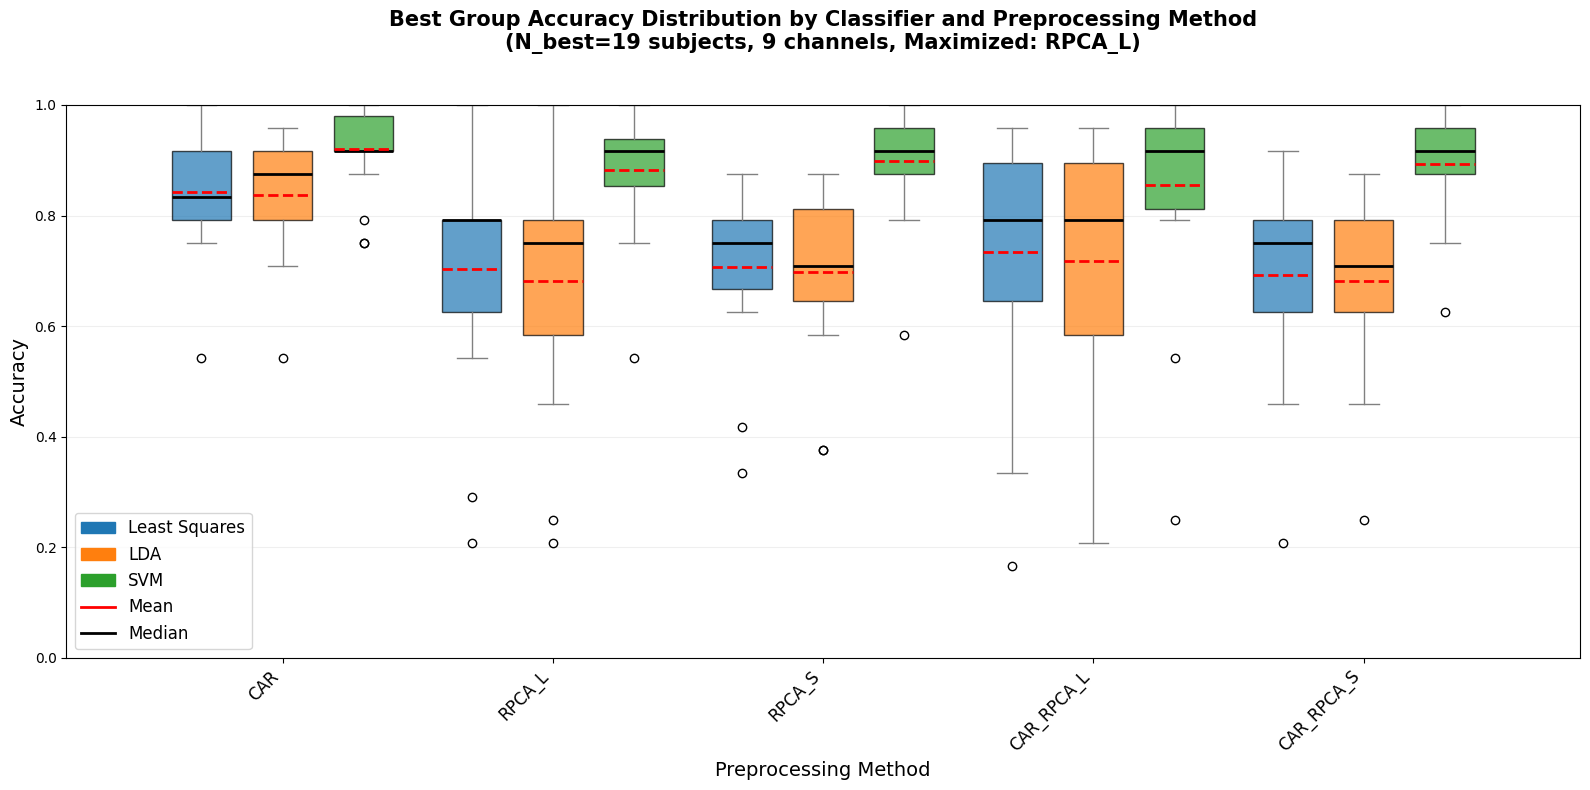

Detailed results saved to results/best_aggregated_accuracies_maximized_for_RPCA_L.csv

Processing maximization for method: RPCA_S
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, LDA: 0.7

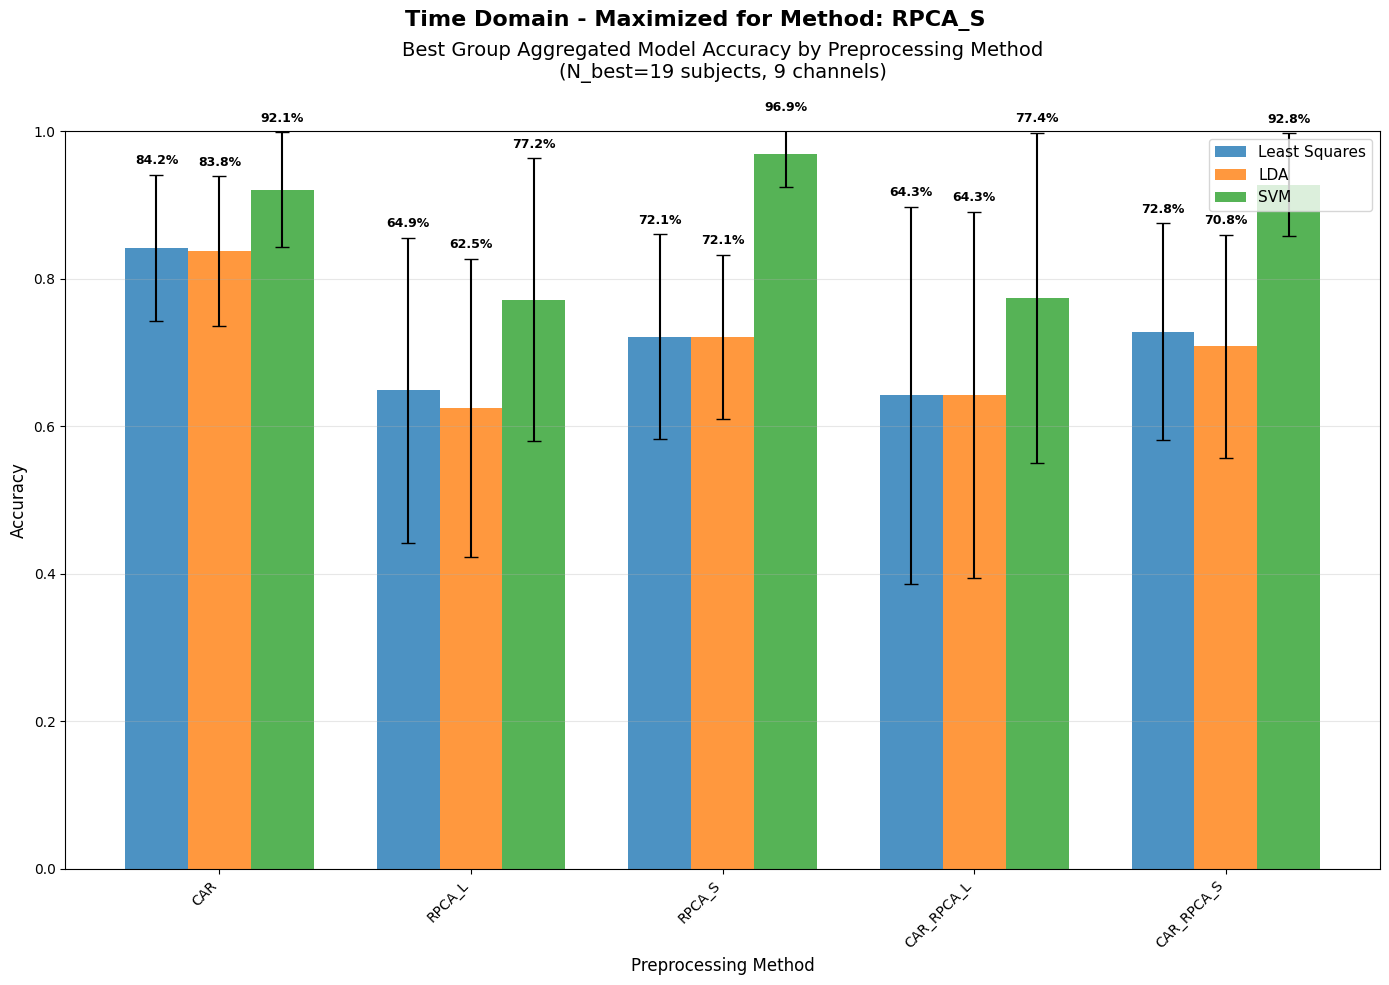

Unified boxplot saved to: results/best_time_domain_domain_unified_boxplot_9ch_maximized_for_RPCA_S.png


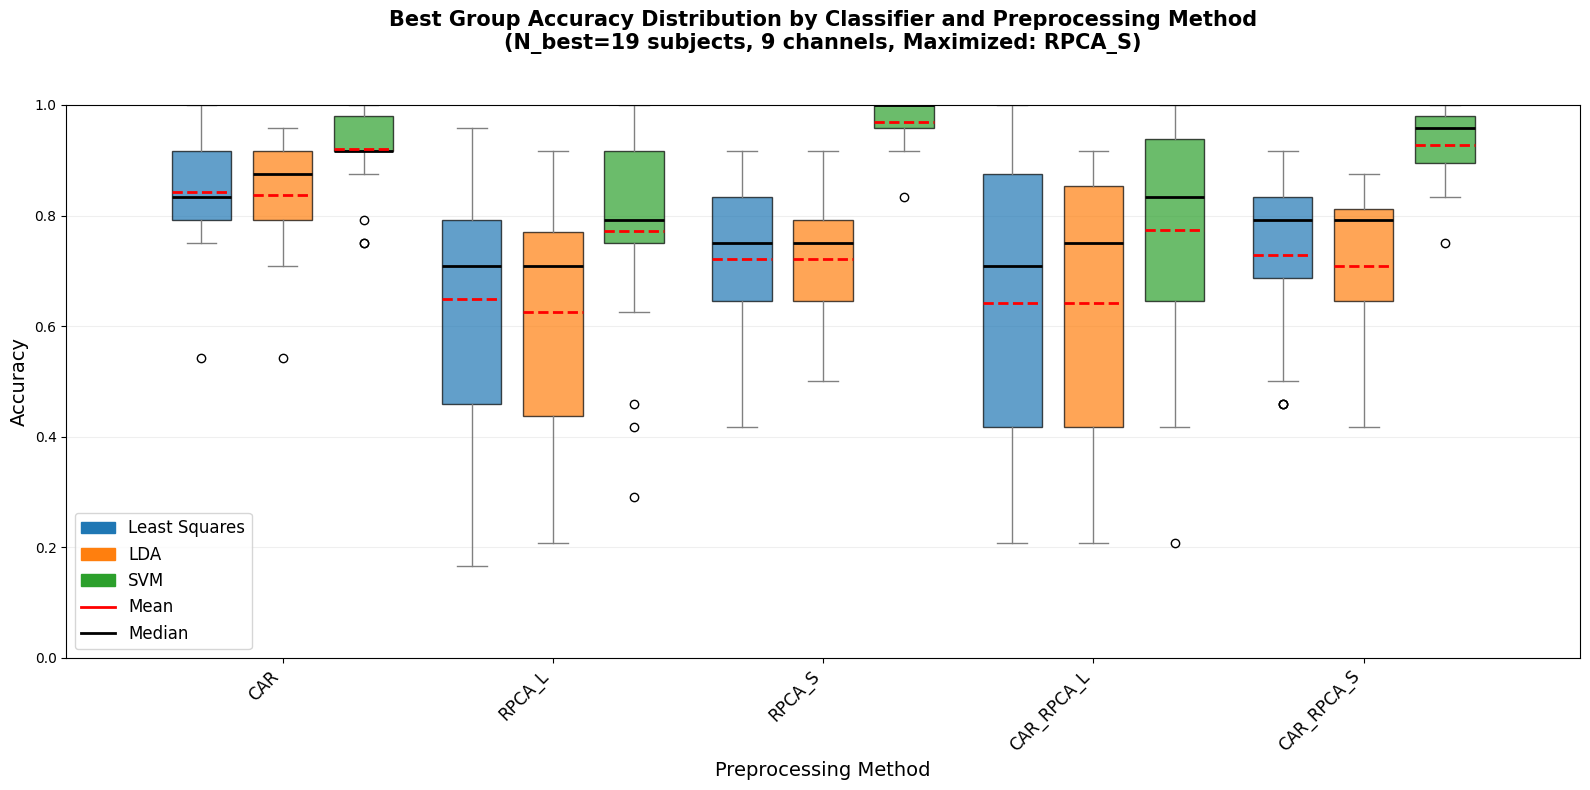

Detailed results saved to results/best_aggregated_accuracies_maximized_for_RPCA_S.csv

Processing maximization for method: CAR_RPCA_L
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, LDA:

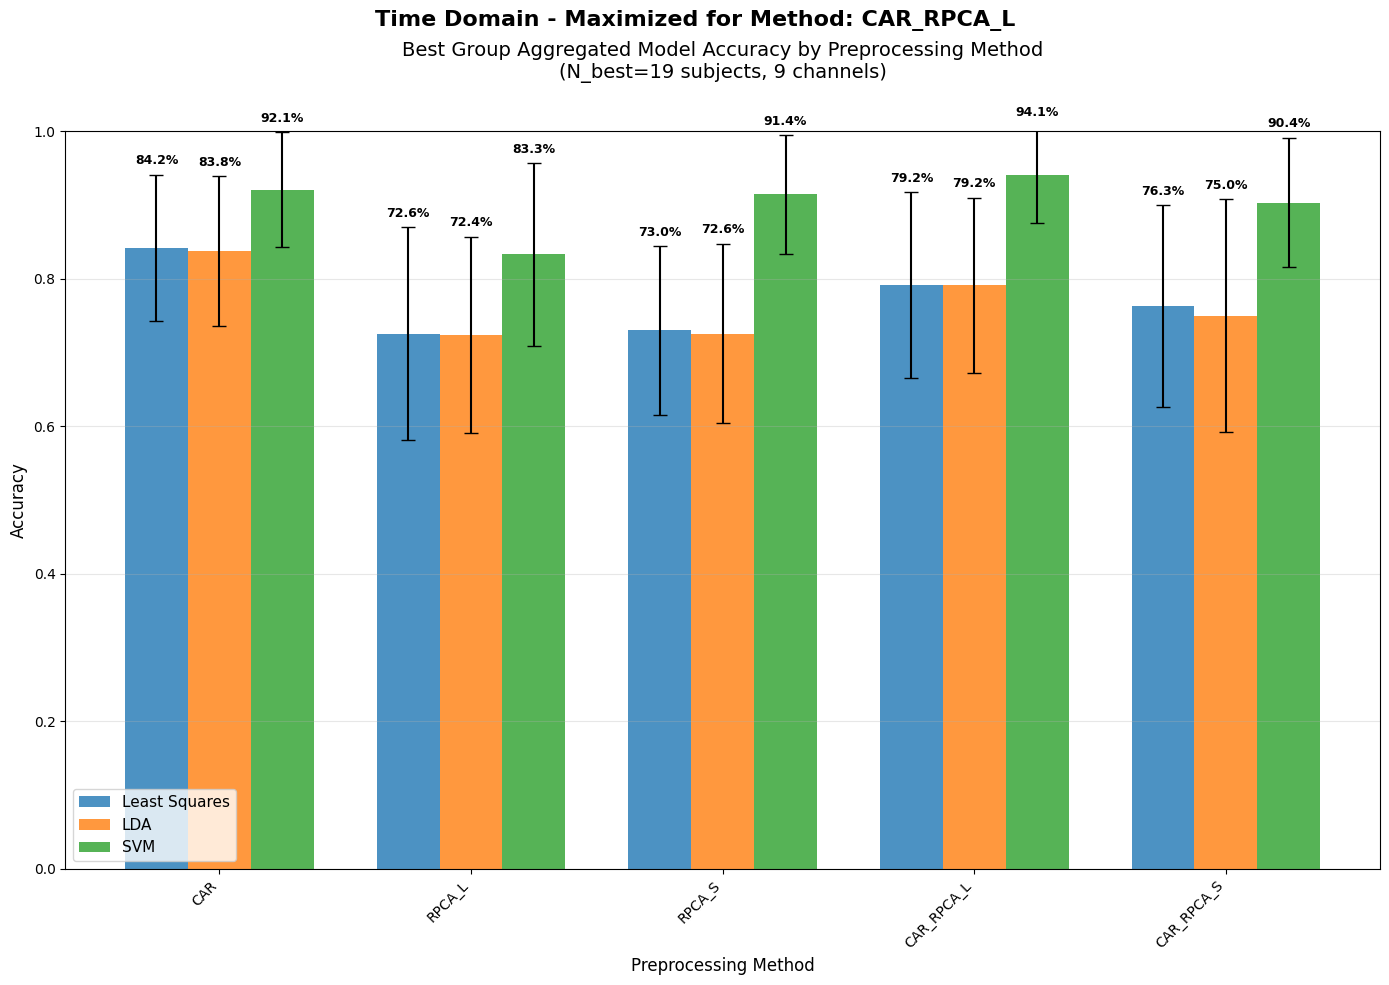

Unified boxplot saved to: results/best_time_domain_domain_unified_boxplot_9ch_maximized_for_CAR_RPCA_L.png


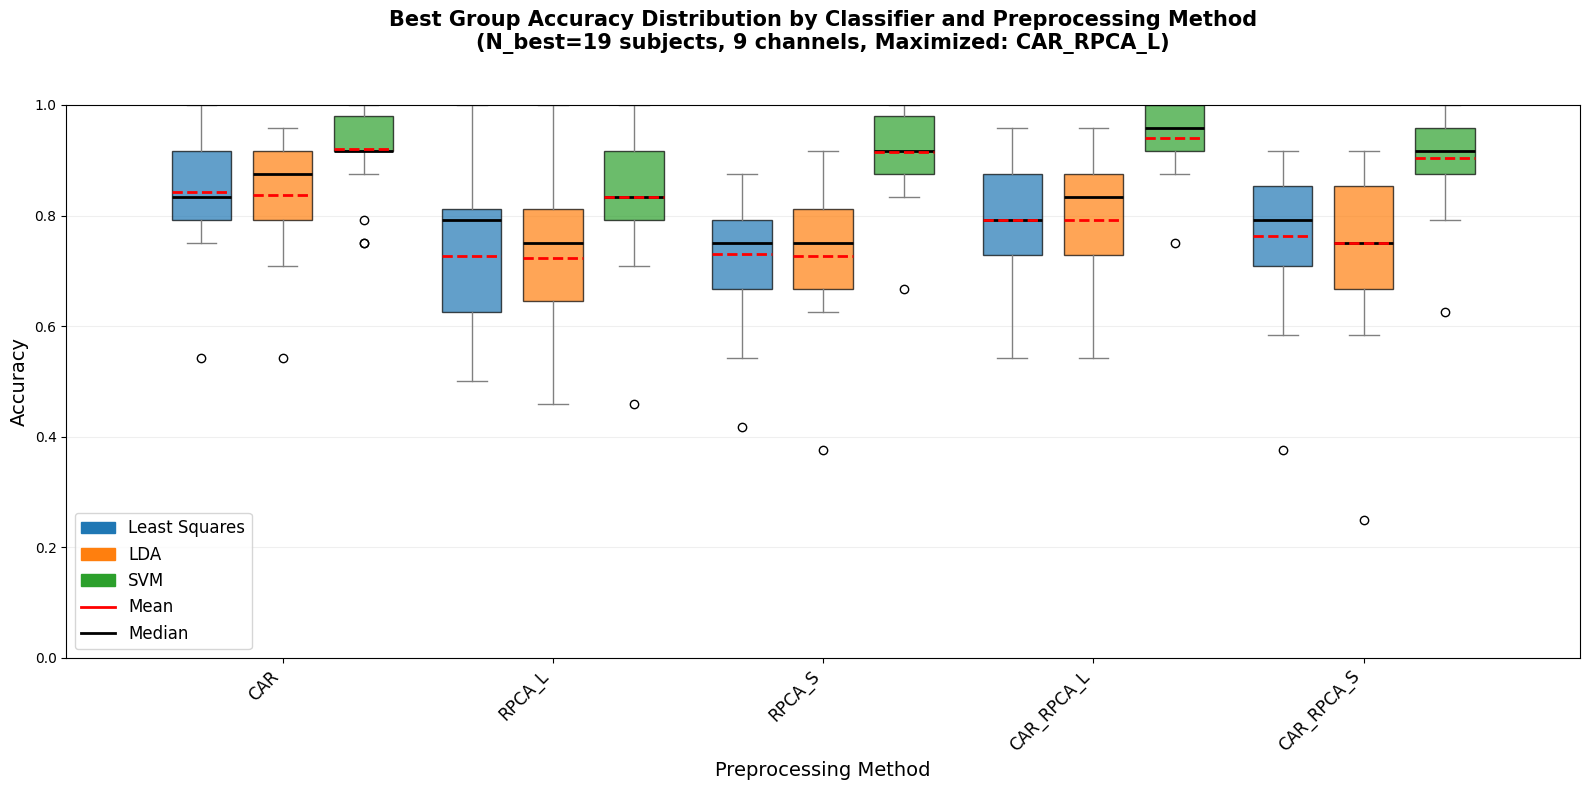

Detailed results saved to results/best_aggregated_accuracies_maximized_for_CAR_RPCA_L.csv

Processing maximization for method: CAR_RPCA_S
Subject 1 - CAR - LS: 0.5417, LDA: 0.5417, SVM: 0.9167
Subject 2 - CAR - LS: 0.5833, LDA: 0.5833, SVM: 0.5833
Subject 3 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 4 - CAR - LS: 0.6667, LDA: 0.6250, SVM: 0.8750
Subject 5 - CAR - LS: 0.7500, LDA: 0.9167, SVM: 1.0000
Subject 6 - CAR - LS: 0.8333, LDA: 0.8333, SVM: 0.7917
Subject 7 - CAR - LS: 0.7500, LDA: 0.7083, SVM: 0.8333
Subject 8 - CAR - LS: 0.7917, LDA: 0.7500, SVM: 0.9167
Subject 9 - CAR - LS: 0.7083, LDA: 0.7083, SVM: 0.9167
Subject 10 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 11 - CAR - LS: 0.6250, LDA: 0.5000, SVM: 0.5000
Subject 12 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.8750
Subject 13 - CAR - LS: 0.7500, LDA: 0.7500, SVM: 0.8750
Subject 14 - CAR - LS: 0.8750, LDA: 0.8750, SVM: 0.9583
Subject 15 - CAR - LS: 0.7917, LDA: 0.7917, SVM: 0.7500
Subject 16 - CAR - LS: 0.7500, 

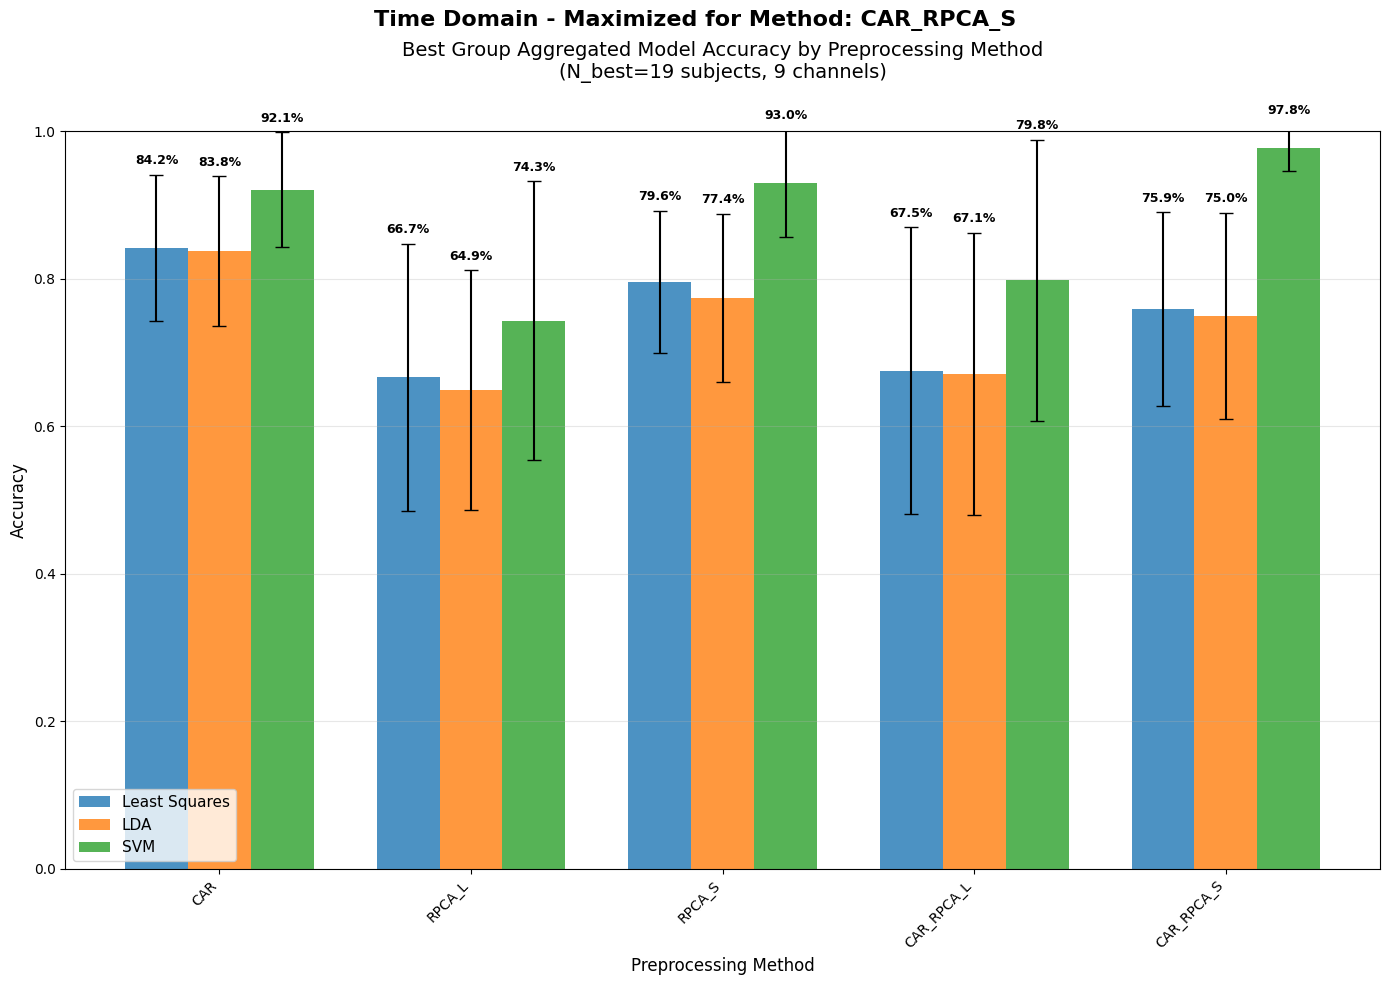

Unified boxplot saved to: results/best_time_domain_domain_unified_boxplot_9ch_maximized_for_CAR_RPCA_S.png


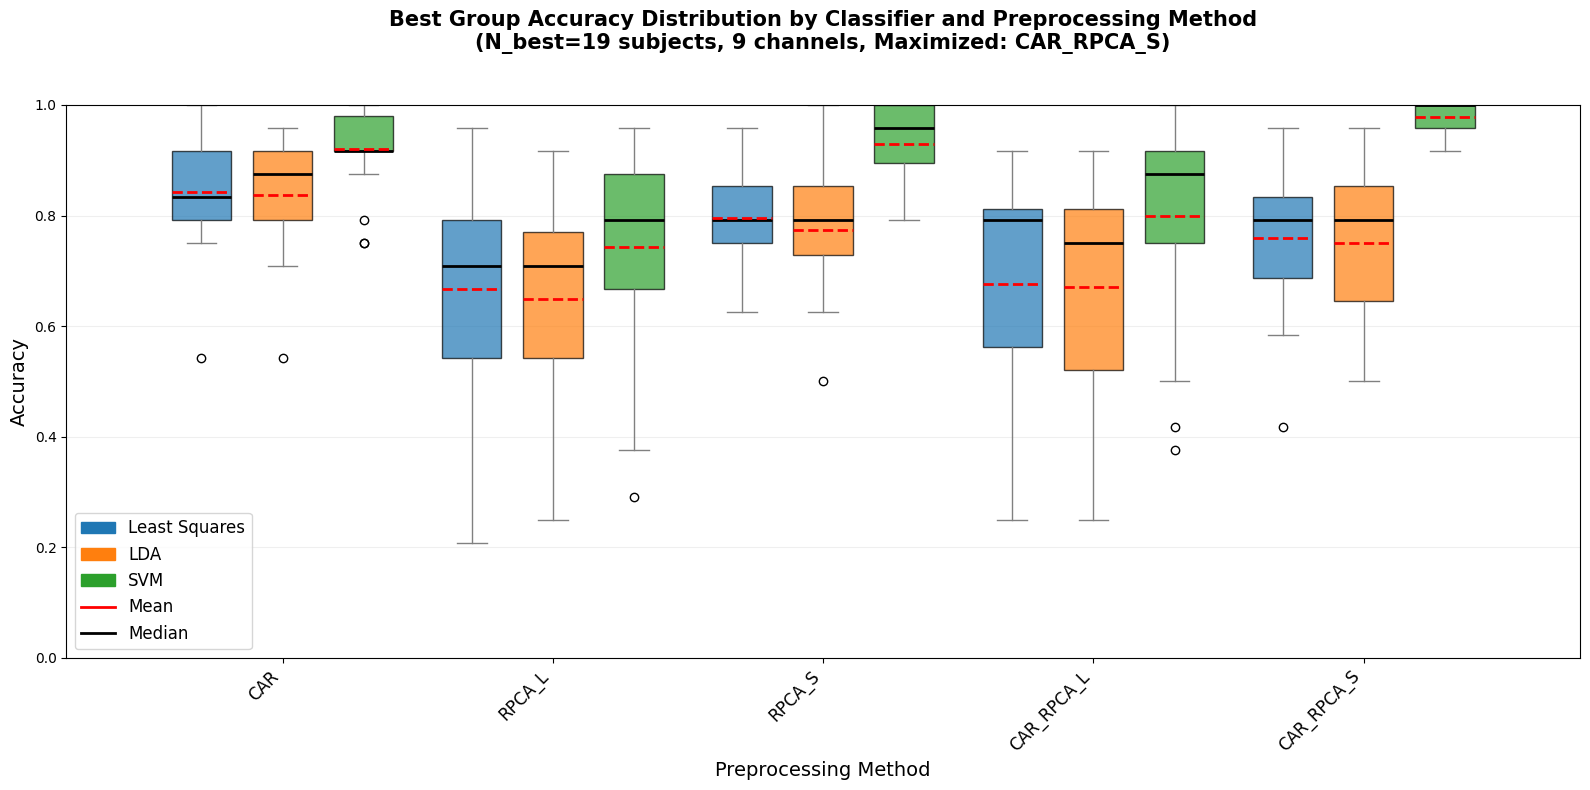

Detailed results saved to results/best_aggregated_accuracies_maximized_for_CAR_RPCA_S.csv

Comprehensive results saved to results/best_comprehensive_time_domain_aggregated_accuracies_all_maximizations.csv

COMPREHENSIVE SUMMARY - MEAN ± STD ACCURACIES (%)
Maximized_for_Method Preprocessing_Method  LS_Mean  LS_Std  LS_Shapiro_Stat  LS_Shapiro_Pval  LS_Ttest_Stat  LS_Ttest_Pval  LDA_Mean  LDA_Std  LDA_Shapiro_Stat  LDA_Shapiro_Pval  LDA_Ttest_Stat  LDA_Ttest_Pval  SVM_Mean  SVM_Std  SVM_Shapiro_Stat  SVM_Shapiro_Pval  SVM_Ttest_Stat  SVM_Ttest_Pval  Num_Subjects
              RPCA_L                  CAR    84.21    9.90             0.89             0.03            NaN            NaN     83.77    10.11              0.89              0.04             NaN             NaN     92.11     7.75              0.82              0.00             NaN             NaN            19
              RPCA_L               RPCA_L    70.39   19.77             0.90             0.06           3.26           0.00

In [ ]:
from scipy.stats import shapiro, ttest_rel
# Perform paired t-tests comparing each method against the first one (baseline)
def compare_against_baseline(accuracies_array):
    """Compare each preprocessing method against the first one (baseline)"""
    baseline = accuracies_array[:, 0]  # First preprocessing method as baseline
    ttest_stats = []
    ttest_pvals = []
    
    for i in range(accuracies_array.shape[1]):
        if i == 0:
            # Baseline vs itself - no test needed
            ttest_stats.append(np.nan)
            ttest_pvals.append(np.nan)
        else:
            # Compare each method against baseline
            stat, pval = ttest_rel(baseline, accuracies_array[:, i])
            ttest_stats.append(stat)
            ttest_pvals.append(pval)
    
    return (np.array(ttest_stats), np.array(ttest_pvals))


# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Initialize storage for aggregated results across all subjects
aggregated_results = {}

# Initialize a structure to collect all accuracies across subjects
for preprocessing_method in ["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]:
    aggregated_results[preprocessing_method] = {
        'ls_accuracies': [],  # Will be 2D: [subject][preprocessing_method]
        'lda_accuracies': [],
        'svm_accuracies': [],
        'preprocessing_methods': preprocessing_methods.copy()
    }

# Process all subjects for each maximization method
for i, maximized_for_method in enumerate(["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]):
    print(f"\nProcessing maximization for method: {maximized_for_method}")
    
    # Collect accuracies for all subjects
    subjects_ls_accuracies = []  # [subject][preprocessing_method]
    subjects_lda_accuracies = []
    subjects_svm_accuracies = []
    
    # Process each subject (data is organized by subject, then by preprocessing method)
    for subject in range(1, NUM_SUBJECTS+1):
        try:
            # Get validation data for this subject and maximized method
            # The data structure is: by_subject[subject-1][preprocessing_method][list_index]
            Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            
            # Calculate accuracies for each preprocessing method for this subject
            subject_ls_accs = []
            subject_lda_accs = []
            subject_svm_accs = []
            
            for j, method in enumerate(preprocessing_methods):
                ls_acc = accuracy_score(Y_vector_validation[j], Y_least_squares_pred_list[j])
                lda_acc = accuracy_score(Y_vector_validation[j], Y_lda_pred_list[j])
                svm_acc = accuracy_score(Y_vector_validation[j], Y_svm_pred_list[j])
                
                subject_ls_accs.append(ls_acc)
                subject_lda_accs.append(lda_acc)
                subject_svm_accs.append(svm_acc)

                if method == 'CAR':
                    print(f"Subject {subject} - {method} - LS: {ls_acc:.4f}, LDA: {lda_acc:.4f}, SVM: {svm_acc:.4f}")
            
            subjects_ls_accuracies.append(subject_ls_accs)
            subjects_lda_accuracies.append(subject_lda_accs)
            subjects_svm_accuracies.append(subject_svm_accs)
            
        except (IndexError, KeyError) as e:
            print(f"Warning: Could not process subject {subject} for method {maximized_for_method}: {e}")
            continue
    
    # Convert to numpy arrays for easier computation
    subjects_ls_accuracies = np.array(subjects_ls_accuracies)
    subjects_lda_accuracies = np.array(subjects_lda_accuracies)
    subjects_svm_accuracies = np.array(subjects_svm_accuracies)

    best_subjects = [0, 2, 5, 7, 9, 13, 14, 16, 19, 21, 24, 25, 26, 27, 29, 30, 31, 33, 34]
    
    subjects_ls_accuracies = subjects_ls_accuracies[best_subjects]
    subjects_lda_accuracies = subjects_lda_accuracies[best_subjects]
    subjects_svm_accuracies = subjects_svm_accuracies[best_subjects]
    
    # Calculate mean and std across subjects for each preprocessing method
    ls_mean = np.mean(subjects_ls_accuracies, axis=0)
    ls_std = np.std(subjects_ls_accuracies, axis=0)
    ls_shapiro = shapiro(subjects_ls_accuracies, axis=0)
    ls_ttest = compare_against_baseline(subjects_ls_accuracies)
    lda_mean = np.mean(subjects_lda_accuracies, axis=0)
    lda_std = np.std(subjects_lda_accuracies, axis=0)
    lda_shapiro = shapiro(subjects_lda_accuracies, axis=0)
    lda_ttest = compare_against_baseline(subjects_lda_accuracies)
    svm_mean = np.mean(subjects_svm_accuracies, axis=0)
    svm_std = np.std(subjects_svm_accuracies, axis=0)
    svm_shapiro = shapiro(subjects_svm_accuracies, axis=0)
    svm_ttest = compare_against_baseline(subjects_svm_accuracies)
    
    # Store aggregated results
    aggregated_results[maximized_for_method]['ls_mean'] = ls_mean
    aggregated_results[maximized_for_method]['ls_std'] = ls_std
    aggregated_results[maximized_for_method]['ls_shapiro_stat'] = ls_shapiro[0]
    aggregated_results[maximized_for_method]['ls_shapiro_pval'] = ls_shapiro[1]
    aggregated_results[maximized_for_method]['ls_ttest_stat'] = compare_against_baseline(subjects_ls_accuracies)[0]
    aggregated_results[maximized_for_method]['ls_ttest_pval'] = compare_against_baseline(subjects_ls_accuracies)[1]
    aggregated_results[maximized_for_method]['lda_mean'] = lda_mean
    aggregated_results[maximized_for_method]['lda_std'] = lda_std
    aggregated_results[maximized_for_method]['lda_shapiro_stat'] = lda_shapiro[0]
    aggregated_results[maximized_for_method]['lda_shapiro_pval'] = lda_shapiro[1]
    aggregated_results[maximized_for_method]['lda_ttest_stat'] = compare_against_baseline(subjects_lda_accuracies)[0]
    aggregated_results[maximized_for_method]['lda_ttest_pval'] = compare_against_baseline(subjects_lda_accuracies)[1]
    aggregated_results[maximized_for_method]['svm_mean'] = svm_mean
    aggregated_results[maximized_for_method]['svm_std'] = svm_std
    aggregated_results[maximized_for_method]['svm_shapiro_stat'] = svm_shapiro[0]
    aggregated_results[maximized_for_method]['svm_shapiro_pval'] = svm_shapiro[1]
    aggregated_results[maximized_for_method]['svm_ttest_stat'] = compare_against_baseline(subjects_svm_accuracies)[0]
    aggregated_results[maximized_for_method]['svm_ttest_pval'] = compare_against_baseline(subjects_svm_accuracies)[1]
    aggregated_results[maximized_for_method]['num_subjects'] = len(subjects_ls_accuracies)
    
    # Print summary statistics
    print(f"\nSummary for {maximized_for_method} (N_best={len(subjects_ls_accuracies)} subjects):")
    for j, method in enumerate(preprocessing_methods):
        print(f"{method}:")
        print(f"  LS: {ls_mean[j]*100:.2f}% ± {ls_std[j]*100:.2f}%")
        print(f"  LDA: {lda_mean[j]*100:.2f}% ± {lda_std[j]*100:.2f}%")
        print(f"  SVM: {svm_mean[j]*100:.2f}% ± {svm_std[j]*100:.2f}%")
    
    # Create aggregated bar chart with error bars
    plt.figure(figsize=(14, 10))
    x = np.arange(len(preprocessing_methods))
    width = 0.25
    
    # Create bars with error bars
    bars_ls = plt.bar(x - width, ls_mean, width, yerr=ls_std, 
                     label='Least Squares', capsize=5, alpha=0.8)
    bars_lda = plt.bar(x, lda_mean, width, yerr=lda_std, 
                      label='LDA', capsize=5, alpha=0.8)
    bars_svm = plt.bar(x + width, svm_mean, width, yerr=svm_std, 
                      label='SVM', capsize=5, alpha=0.8)
    
    # Add mean values above each bar
    for idx, bar in enumerate(bars_ls):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + ls_std[idx] + 0.01, 
                f"{ls_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_lda):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + lda_std[idx] + 0.01, 
                f"{lda_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_svm):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + svm_std[idx] + 0.01, 
                f"{svm_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.xlabel('Preprocessing Method', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Best Group Aggregated Model Accuracy by Preprocessing Method\n(N_best={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)\n\n', fontsize=14)
    plt.suptitle(f'Time Domain - Maximized for Method: {maximized_for_method}', fontsize=16, fontweight='bold')
    plt.xticks(x, preprocessing_methods, rotation=45, ha='right')
    plt.ylim(0, min(1.0, np.max([ls_mean + ls_std, lda_mean + lda_std, svm_mean + svm_std]) + 0.1))
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'results/best_time_domain_aggregated_accuracy_comparison_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png', 
                dpi=300, bbox_inches='tight')
    print(f"Aggregated accuracy chart saved to results/best_time_domain_aggregated_accuracy_comparison_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png")
    
    # Display the plot
    plt.show()

    # -----------------------------------------
    # Unified matplotlib boxplot for all classifiers and preprocessing methods
    # -----------------------------------------

    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    # Data layout: preprocessing_methods x classifiers x subjects
    data = [
        subjects_ls_accuracies,   # shape: subjects x methods
        subjects_lda_accuracies,
        subjects_svm_accuracies
    ]  # List of [subjects x methods] arrays

    classifier_names = ['Least Squares', 'LDA', 'SVM']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # For LS, LDA, SVM

    num_methods = len(preprocessing_methods)
    num_classifiers = len(classifier_names)

    fig, ax = plt.subplots(figsize=(16,8))

    box_width = 0.22
    box_distance = 0.08
    total_width = num_classifiers * box_width + (num_classifiers-1)*box_distance
    xs = np.arange(num_methods)

    # Collect boxplot positions and data
    boxplot_data = []
    positions = []
    color_patches = []

    for i, method in enumerate(preprocessing_methods):
        for j, (clf_accs, clf_name) in enumerate(zip(data, classifier_names)):
            # For each classifier for this method, get accuracy for all subjects (the column)
            boxplot_data.append(clf_accs[:,i])
            # Position: spaced within each group
            pos = i - total_width/2 + box_width/2 + j*(box_width+box_distance)
            positions.append(pos)
            if i == 0:
                color_patches.append(mpatches.Patch(color=colors[j], label=clf_name))

    # Draw single combined boxplot using matplotlib
    bp = ax.boxplot(
        boxplot_data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        showfliers=True
    )

    # Color the boxes
    for k, box in enumerate(bp['boxes']):
        classifier_idx = k % num_classifiers
        box.set(facecolor=colors[classifier_idx], alpha=0.7)
    for k, median in enumerate(bp['medians']):
        median.set(color='black', linewidth=2)
    for k, mean in enumerate(bp['means']):
        mean.set(color='red', linewidth=2)
    for k, whisker in enumerate(bp['whiskers']):
        whisker.set(color='grey')
    for k, cap in enumerate(bp['caps']):
        cap.set(color='grey')

    # X-axis: Set ticks at center of each group
    ax.set_xticks(xs)
    ax.set_xticklabels(preprocessing_methods, rotation=45, ha='right', fontsize=12)

    # Y-label and title
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Preprocessing Method', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.2)

    # Main title and subtitle
    ax.set_title(
        f"Best Group Accuracy Distribution by Classifier and Preprocessing Method"
        f"\n(N_best={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels, Maximized: {maximized_for_method})\n\n",
        fontsize=15, fontweight='bold'
    )

    # Legends for classifier colors, means, and medians
    handles = color_patches.copy()
    # Add legend for mean (red line) and median (black line)
    mean_line = mlines.Line2D([], [], color='red', linewidth=2, label='Mean')
    median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
    handles.extend([mean_line, median_line])

    ax.legend(handles=handles, fontsize=12)
    plt.tight_layout()

    # Save
    plt.savefig(
        f'results/best_time_domain_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png', 
        dpi=300, bbox_inches='tight'
    )
    print(f"Unified boxplot saved to: results/best_time_domain_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png")
    plt.show()
    # -----------------------------------------
    
    # Create detailed results DataFrame for this maximization method
    detailed_results = []
    for j, method in enumerate(preprocessing_methods):
        detailed_results.append({
            'Maximized_for_Method': maximized_for_method,
            'Preprocessing_Method': method,
            'LS_Mean': ls_mean[j] * 100,
            'LS_Std': ls_std[j] * 100,
            'LS_Shapiro_Stat': ls_shapiro[0][j],
            'LS_Shapiro_Pval': ls_shapiro[1][j],
            'LS_Ttest_Stat': compare_against_baseline(subjects_ls_accuracies)[0][j],
            'LS_Ttest_Pval': compare_against_baseline(subjects_ls_accuracies)[1][j],
            'LDA_Mean': lda_mean[j] * 100,
            'LDA_Std': lda_std[j] * 100,
            'LDA_Shapiro_Stat': lda_shapiro[0][j],
            'LDA_Shapiro_Pval': lda_shapiro[1][j],
            'LDA_Ttest_Stat': compare_against_baseline(subjects_lda_accuracies)[0][j],
            'LDA_Ttest_Pval': compare_against_baseline(subjects_lda_accuracies)[1][j],
            'SVM_Mean': svm_mean[j] * 100,
            'SVM_Std': svm_std[j] * 100,
            'SVM_Shapiro_Stat': svm_shapiro[0][j],
            'SVM_Shapiro_Pval': svm_shapiro[1][j],
            'SVM_Ttest_Stat': compare_against_baseline(subjects_svm_accuracies)[0][j],
            'SVM_Ttest_Pval': compare_against_baseline(subjects_svm_accuracies)[1][j],
            'Num_Subjects': len(subjects_ls_accuracies)
        })
    
    # Save detailed results to CSV for this maximization method
    detailed_df = pd.DataFrame(detailed_results)
    csv_filename = f'results/best_aggregated_accuracies_maximized_for_{maximized_for_method}.csv'
    detailed_df.to_csv(csv_filename, index=False)
    print(f"Detailed results saved to {csv_filename}")

# Create a comprehensive summary DataFrame combining all maximization methods
all_results = []
for maximized_method, results in aggregated_results.items():
    if 'ls_mean' in results:  # Check if processing was successful
        for j, preprocessing_method in enumerate(results['preprocessing_methods']):
            all_results.append({
                'Maximized_for_Method': maximized_method,
                'Preprocessing_Method': preprocessing_method,
                'LS_Mean': results['ls_mean'][j] * 100,
                'LS_Std': results['ls_std'][j] * 100,
                'LS_Shapiro_Stat': results['ls_shapiro_stat'][j],
                'LS_Shapiro_Pval': results['ls_shapiro_pval'][j],
                'LS_Ttest_Stat': results['ls_ttest_stat'][j],
                'LS_Ttest_Pval': results['ls_ttest_pval'][j],
                'LDA_Mean': results['lda_mean'][j] * 100,
                'LDA_Std': results['lda_std'][j] * 100,
                'LDA_Shapiro_Stat': results['lda_shapiro_stat'][j],
                'LDA_Shapiro_Pval': results['lda_shapiro_pval'][j],
                'LDA_Ttest_Stat': results['lda_ttest_stat'][j],
                'LDA_Ttest_Pval': results['lda_ttest_pval'][j],
                'SVM_Mean': results['svm_mean'][j] * 100,
                'SVM_Std': results['svm_std'][j] * 100,
                'SVM_Shapiro_Stat': results['svm_shapiro_stat'][j],
                'SVM_Shapiro_Pval': results['svm_shapiro_pval'][j],
                'SVM_Ttest_Stat': results['svm_ttest_stat'][j],
                'SVM_Ttest_Pval': results['svm_ttest_pval'][j],
                'Num_Subjects': results['num_subjects']
            })

# Save comprehensive results
if all_results:
    comprehensive_df = pd.DataFrame(all_results)
    comprehensive_df.to_csv('results/best_comprehensive_time_domain_aggregated_accuracies_all_maximizations.csv', index=False)
    print(f"\nComprehensive results saved to results/best_comprehensive_time_domain_aggregated_accuracies_all_maximizations.csv")
    
    # Display summary table
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY - MEAN ± STD ACCURACIES (%)")
    print("="*100)
    print(comprehensive_df.to_string(index=False, float_format='%.2f'))

print(f"\n✅ Processing complete! Generated aggregated results for all maximization methods.")
